In [99]:
# import copy
from collections.abc import Iterable
import functools
import itertools
import operator
from matplotlib import pyplot as plt

import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import math
import random
from pprint import pprint
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.sparse import hstack, vstack, csr_matrix
import scipy

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import joblib

import seaborn as sns

import sys
import os

from config import demographics, vital_sign_vars, lab_vars, treatment_vars, vent_vars, guideline_vars, ffill_windows_clinical, SAMPLE_TIME_H
from config import fio2_bins, peep_bins, tv_bins
import safety
import utils
from utils import to_discrete_action

In [223]:
scalers_dir = '../preprocessing/scalers/'
data_dir = '../mimic-data/'
seed = 12

SHAPING = 'avgpotential2' # TODO: timothy trace code
# SHAPING = False
COMPLIANCE_SCALAR = 0.0 # should be in [0, 5] # TODO: timothy trace code: how much obay the constraint
UNSAFETY_PROB = 1.0 # should be in [0.0,1.0] or {0,0, 1.0} until safety probs implemented
GAMMA = 0.99
n_states = 650 # according to Peine's paper
CREATE_TRAJS = True
if not SHAPING:
    shaping_name = 'unshaped'
else:
    shaping_name = SHAPING + '-' + str(COMPLIANCE_SCALAR)
np.random.seed(seed)
random.seed(seed)
all_var_types = [
    vital_sign_vars,
    lab_vars,
    treatment_vars,
    vent_vars,
    guideline_vars,
]
all_vars = functools.reduce(operator.add, all_var_types)

In [101]:
if CREATE_TRAJS:
    train_set = pd.read_csv(data_dir + 'train_imputed_{}.csv'.format(seed))
    clinical_train_scaler = joblib.load(scalers_dir + 'train/clinical_std_scaler_{}.bin'.format(seed))
    demographics_train_scaler = joblib.load(scalers_dir + 'train/demographics_std_scaler_{}.bin'.format(seed))

    test_set = pd.read_csv(data_dir + 'test_ffilled_{}.csv'.format(seed))
    val_set = pd.read_csv(data_dir + 'validation_ffilled_{}.csv'.format(seed))

    knn_imputer = joblib.load(scalers_dir + 'train/knn_imputer_{}.bin'.format(seed))
    scalers = {}
    for var in all_vars + demographics:
        try:
            scalers[var] = joblib.load(scalers_dir + 'train/{}_std_scaler_{}.bin'.format(var, seed))
        except FileNotFoundError:
            pass

    # TODO: FIX for test and validation sets: scaling (w/ train scaler?), knn imputation (w/ train clusterer), scaling (w/ train scaler?) and clustering (w/ train clusterer)
    # for df in (test_set, val_set):
    #     vars_to_impute = []
    #     for var in all_vars:
    #         if pd.api.types.is_numeric_dtype(df[var]):
    #             ffilled = var + '_imp'
    #             non_nas = df[~df[ffilled].isna()][ffilled].to_numpy().reshape(-1,1)
    #             scaled = scalers[var].transform(non_nas)
    #             scaledvarname = ffilled + '_scaled'
    #             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
    #             vars_to_impute.append(scaledvarname)
    #     for var in demographics:
    #         if pd.api.types.is_numeric_dtype(df[var]):
    #             non_nas = df[~df[var].isna()][var].to_numpy().reshape(-1, 1)
    #             scaled = scalers[var].transform(df[var].to_numpy().reshape(-1,1))
    #             scaledvarname = var + '_scaled'
    #             df[scaledvarname] = pd.Series(scaled.reshape(1,-1)[0])
    #             vars_to_impute.append(scaledvarname)
    #     knn_imputed_vars = list(map(lambda x: x + '_impknn', vars_to_impute))
    #     imputed = knn_imputer.transform(df[vars_to_impute].to_numpy())
    #     df.loc[:, knn_imputed_vars] = imputed

In [102]:
if CREATE_TRAJS:
    # NOTE: these have not been rescaled after imputation
    test_set.to_csv(data_dir + 'test_imputed_{}.csv'.format(seed))
    val_set.to_csv(data_dir + 'validation_imputed_{}.csv'.format(seed))

In [103]:
if CREATE_TRAJS:
    var_to_state_var = {}
    for var in all_vars + demographics:
        if var not in ('vent_duration_h', 'hospmort', 'mort90day'):
            if var + '_imp_scaled_impknn' in train_set.columns:
                var_to_state_var[var] = var + '_imp_scaled_impknn'
            elif var + '_scaled_impknn' in train_set.columns:
                var_to_state_var[var] = var + '_scaled_impknn'

    # TODO: validate if this contains all vars
    state_variables = list(var_to_state_var.values())

In [104]:
if CREATE_TRAJS:
    longest_sv = max(map(len, state_variables))
    for sv in state_variables:
        print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn              : -0.0129 0.2138 1.0507
sirs_imp_scaled_impknn              : 0.0100 -0.1035 1.0049
gcs_imp_scaled_impknn               : 0.0563 0.1245 1.0387
heartrate_imp_scaled_impknn         : 0.0035 -0.0549 1.0044
sysbp_imp_scaled_impknn             : -0.0285 -0.1591 0.9903
meanbp_imp_scaled_impknn            : -0.0199 -0.1282 0.9873
diasbp_imp_scaled_impknn            : -0.0084 -0.0810 1.0028
shockindex_imp_scaled_impknn        : 0.0158 -0.1089 1.0355
resprate_imp_scaled_impknn          : 0.0370 -0.0878 1.0096
spo2_imp_scaled_impknn              : -0.0635 0.1250 0.9924
tempc_imp_scaled_impknn             : -0.0360 -0.0528 0.9902
potassium_imp_scaled_impknn         : 0.0451 -0.0876 0.9812
sodium_imp_scaled_impknn            : -0.0266 -0.0732 0.9953
chloride_imp_scaled_impknn          : -0.0232 0.0197 1.0103
glucose_imp_scaled_impknn           : 0.0122 -0.1884 1.0248
bun_imp_scaled_impknn               : 0.0793 -0.2459 1.0705
creatinine_imp_scaled_impknn        

In [105]:
if CREATE_TRAJS:
    # NOTE: mirror the changes made here in the 'unscale' logic
    rescaler = StandardScaler()

    rescaled = rescaler.fit_transform(train_set[state_variables])
    rs_state_varnames = [var + '_rescaled' for var in state_variables]
    train_set[rs_state_varnames] = rescaled

    rescaled_test = rescaler.transform(test_set[state_variables])
    test_set[rs_state_varnames] = rescaled_test

In [106]:
if CREATE_TRAJS:
    clusterer = KMeans(n_clusters=n_states)
    train_clusters = clusterer.fit_predict(train_set[rs_state_varnames])
    test_clusters = clusterer.predict(test_set[rs_state_varnames])

c:\Users\hmilab\Anaconda3\envs\VM_RL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


timothy trace code: show 650 state counts

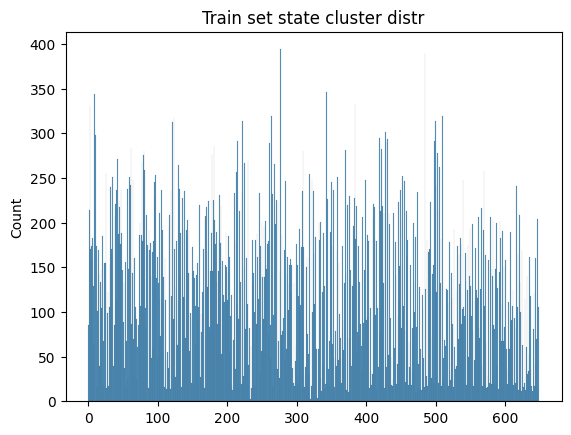

In [107]:
if CREATE_TRAJS:
    sns.histplot(train_clusters, bins=n_states)
    plt.title('Train set state cluster distr')

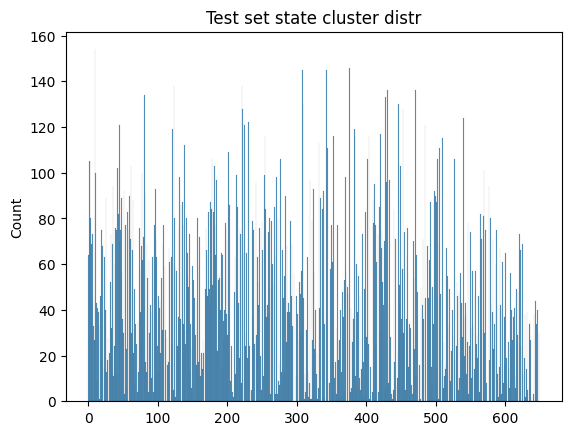

In [108]:
if CREATE_TRAJS:
    sns.histplot(test_clusters, bins=n_states)
    plt.title('Test set state cluster distr')

In [109]:
if CREATE_TRAJS:
    clusters = pd.Series(train_clusters)
    test_clusters_series = pd.Series(test_clusters)
    clusters.value_counts()

In [110]:
if CREATE_TRAJS:
    longest_sv = max(map(len, rs_state_varnames))
    for sv in rs_state_varnames:
        print(("{:<" + str(longest_sv) +"}: {:.4f} {:.4f} {:.4f}").format(sv, train_set[sv].mean(), train_set[sv].median(), train_set[sv].var()))

sofa_imp_scaled_impknn_rescaled              : 0.0000 0.2213 1.0000
sirs_imp_scaled_impknn_rescaled              : -0.0000 -0.1133 1.0000
gcs_imp_scaled_impknn_rescaled               : -0.0000 0.0669 1.0000
heartrate_imp_scaled_impknn_rescaled         : -0.0000 -0.0583 1.0000
sysbp_imp_scaled_impknn_rescaled             : 0.0000 -0.1312 1.0000
meanbp_imp_scaled_impknn_rescaled            : 0.0000 -0.1091 1.0000
diasbp_imp_scaled_impknn_rescaled            : -0.0000 -0.0725 1.0000
shockindex_imp_scaled_impknn_rescaled        : -0.0000 -0.1225 1.0000
resprate_imp_scaled_impknn_rescaled          : -0.0000 -0.1242 1.0000
spo2_imp_scaled_impknn_rescaled              : 0.0000 0.1893 1.0000
tempc_imp_scaled_impknn_rescaled             : 0.0000 -0.0169 1.0000
potassium_imp_scaled_impknn_rescaled         : -0.0000 -0.1340 1.0000
sodium_imp_scaled_impknn_rescaled            : -0.0000 -0.0467 1.0000
chloride_imp_scaled_impknn_rescaled          : 0.0000 0.0427 1.0000
glucose_imp_scaled_impknn_resc

In [111]:
if CREATE_TRAJS:
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(train_set[rs_state_varnames])

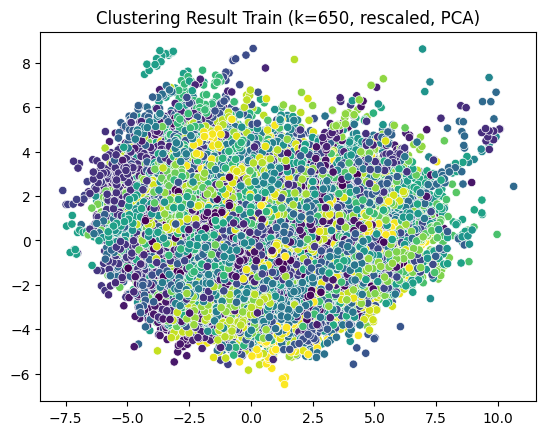

In [230]:
# TODO: timothy trace code
if CREATE_TRAJS:
    #pca = PCA(n_components=2)
    #pca_result = pca.fit_transform(test_set[rs_state_varnames])
    pca_result = pca.transform(train_set[rs_state_varnames])
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], c=train_clusters)
    plt.title('Clustering Result Train (k={}, rescaled, PCA)'.format(n_states))

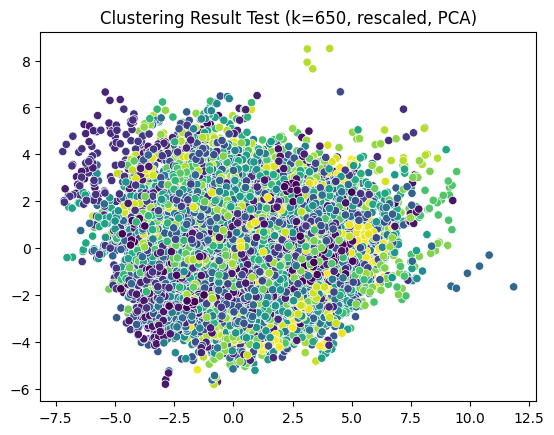

In [112]:
if CREATE_TRAJS:
    #pca = PCA(n_components=2)
    #pca_result = pca.fit_transform(test_set[rs_state_varnames])
    pca_result = pca.transform(test_set[rs_state_varnames])
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], c=test_clusters)
    plt.title('Clustering Result Test (k={}, rescaled, PCA)'.format(n_states))

In [113]:
if CREATE_TRAJS:
    print("""silhouette: {}, [-1, 1], higher is better
    calinksi-harabasz: {}, higher is better
    davies-bouldin: {}, [0, ∞], lower is better""".format(
        metrics.silhouette_score(train_set[rs_state_varnames], train_clusters),
        metrics.calinski_harabasz_score(train_set[rs_state_varnames], train_clusters),
        metrics.davies_bouldin_score(train_set[rs_state_varnames], train_clusters)))

silhouette: 0.05322685409604957, [-1, 1], higher is better
    calinksi-harabasz: 153.60375832112842, higher is better
    davies-bouldin: 2.3378949735321073, [0, ∞], lower is better


In [114]:
if CREATE_TRAJS:
    train_set['state'] = clusters
    test_set['state'] = test_clusters_series

# Unscale - back to original and interpretable space

In [115]:
if CREATE_TRAJS:
    # This step is spurious for now, as there is no imputation after rescaling
    un_rescaled_state_vars = rescaler.inverse_transform(train_set[rs_state_varnames])
    un_rescaled_state_vars_test = rescaler.inverse_transform(test_set[rs_state_varnames])

    clinical_scaled_varnames = [var + '_impknn' for var in joblib.load('../preprocessing/scalers/train/clinical_std_varnames_{}.bin'.format(seed))]
    demographics_scaled_varnames = [var + '_impknn' for var in joblib.load('../preprocessing/scalers/train/demographics_std_varnames_{}.bin'.format(seed))]
    unscaled_clinical_vars = clinical_train_scaler.inverse_transform(train_set[clinical_scaled_varnames])
    unscaled_clinical_vars_test = clinical_train_scaler.inverse_transform(test_set[clinical_scaled_varnames])
    unscaled_demo_vars = demographics_train_scaler.inverse_transform(train_set[demographics_scaled_varnames])
    unscaled_demo_vars_test = demographics_train_scaler.inverse_transform(test_set[demographics_scaled_varnames])


    unscaled_clinical_varnames = [var + '_unscaled' for var in clinical_scaled_varnames]
    unscaled_demographics_varnames = [var + '_unscaled' for var in demographics_scaled_varnames]
    train_set[unscaled_clinical_varnames] = unscaled_clinical_vars
    test_set[unscaled_clinical_varnames] = unscaled_clinical_vars_test
    train_set[unscaled_demographics_varnames] = unscaled_demo_vars
    test_set[unscaled_demographics_varnames] = unscaled_demo_vars_test

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3399159209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[unscaled_demographics_varnames] = unscaled_demo_vars
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3399159209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set[unscaled_demographics_varnames] = unscaled_demo_vars
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3399159209.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [116]:
if CREATE_TRAJS:
    # validation unscaling
    #  * does not introduce NaNs
    #  * does not change known values (by some error margin)
    clinical_varname_pairs = list(zip(unscaled_clinical_varnames, map(lambda x: x.replace("_imp_scaled_impknn", ""), clinical_scaled_varnames)))
    demo_varname_pairs = list(zip(unscaled_demographics_varnames, map(lambda x: x.replace("_scaled_impknn", ""), demographics_scaled_varnames)))
    all_varname_pairs = clinical_varname_pairs + demo_varname_pairs
    for (unscaled, original) in all_varname_pairs:
        print(unscaled, original)
        # check that the number of NaNs for unscaled is less or equal than original
        assert train_set[unscaled].isna().sum() <= train_set[original].isna().sum(), "Unscaling has introduced NaNs in train set"
        assert test_set[unscaled].isna().sum() <= test_set[original].isna().sum(), "Unscaling has introduced NaNs in test set"
        # calculate difference between unscaled and original value
        difference = np.absolute(train_set[~train_set[unscaled].isna()][unscaled] - train_set[~train_set[unscaled].isna()][original])
        difference_test = np.absolute(test_set[~test_set[unscaled].isna()][unscaled] - test_set[~test_set[unscaled].isna()][original])
        # difference should be small OR the original should be NaN.
        assert ((difference < 0.0001) | train_set[~train_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in train set".format(original)
        assert ((difference_test < 0.0001) | test_set[~test_set[unscaled].isna()][original].isna()).all(), "Unscaling introduced errors for variable '{}' in test set".format(original)

sofa_imp_scaled_impknn_unscaled sofa
sirs_imp_scaled_impknn_unscaled sirs
gcs_imp_scaled_impknn_unscaled gcs
heartrate_imp_scaled_impknn_unscaled heartrate
sysbp_imp_scaled_impknn_unscaled sysbp
meanbp_imp_scaled_impknn_unscaled meanbp
diasbp_imp_scaled_impknn_unscaled diasbp
shockindex_imp_scaled_impknn_unscaled shockindex
resprate_imp_scaled_impknn_unscaled resprate
spo2_imp_scaled_impknn_unscaled spo2
tempc_imp_scaled_impknn_unscaled tempc
potassium_imp_scaled_impknn_unscaled potassium
sodium_imp_scaled_impknn_unscaled sodium
chloride_imp_scaled_impknn_unscaled chloride
glucose_imp_scaled_impknn_unscaled glucose
bun_imp_scaled_impknn_unscaled bun
creatinine_imp_scaled_impknn_unscaled creatinine
magnesium_imp_scaled_impknn_unscaled magnesium
calcium_imp_scaled_impknn_unscaled calcium
ionizedcalcium_imp_scaled_impknn_unscaled ionizedcalcium
carbondioxide_imp_scaled_impknn_unscaled carbondioxide
bilirubin_imp_scaled_impknn_unscaled bilirubin
albumin_imp_scaled_impknn_unscaled albumin
h

## Compute derived values
- normalized tidal volume: tv in ml/Kg of adult ideal body weight

In [117]:
if CREATE_TRAJS:
    # derived variables based on imputed / normalized values
    # - tidal_volume
    train_set['tv_derived'] = train_set['tidal_volume_imp_scaled_impknn_unscaled'] / train_set['adult_ibw_scaled_impknn_unscaled']
    test_set['tv_derived'] = test_set['tidal_volume_imp_scaled_impknn_unscaled'] / test_set['adult_ibw_scaled_impknn_unscaled']

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3786897168.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['tv_derived'] = train_set['tidal_volume_imp_scaled_impknn_unscaled'] / train_set['adult_ibw_scaled_impknn_unscaled']
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3786897168.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['tv_derived'] = test_set['tidal_volume_imp_scaled_impknn_unscaled'] / test_set['adult_ibw_scaled_impknn_unscaled']


In [118]:
# if CREATE_TRAJS:
#     (train_adult_ibwdult_ibw_scaled_impknn_unscaled < 0).sum()

# Action space discretization
The action space consists of three dimensions:
* Tidal volume (ml/Kg), where Kg refers to the ideal body weight
* PEEP (cmH20) positive end-expiration pressure
* FiO2 (%) fraction of inspired oxygen

These three dimensions are each discretized into 7 bins, rendering a total of 7^3 = 343 actions.  
The action bins are defined per dimension and according to Peine in ``config.py``.
Here we map all possible actions to a discrete identifier action.

In [119]:
if CREATE_TRAJS:
    # a definition of all actions
    action_bin_definition = list(itertools.product(tv_bins, fio2_bins, peep_bins))
    # the lower bounds for the three variables in the action space
    lower_bounds = [[var[0] for var in ranges] for ranges in action_bin_definition] 

In [120]:
if CREATE_TRAJS:
    assert to_discrete_action(1, 25, 0) == 0, "the first action does not have id 0"             # the first action
    assert to_discrete_action(1, 25, 5) == 1, "the second action does not have id 1"             # the second action
    assert to_discrete_action(1, 25, sys.maxsize) == 6, "the last action in the third dimension does not have id 6"   # very high value for 3rd dimension (peep)
    assert to_discrete_action(2.5, 25, 0) == 7*7, "the last action in the second dimension does not have id 7*7"         # second bin for the first dimension (tv)
    assert to_discrete_action(sys.maxsize,
                              sys.maxsize,
                              sys.maxsize) == 7**3 - 1, "an action with very high values does not have id 7**3 -1"   # very high value for all bins

In [121]:
if CREATE_TRAJS:
    tv_clinical = 'tv_derived'
    peep_clinical = 'peep_imp_scaled_impknn_unscaled'
    fio2_clinical = 'fio2_imp_scaled_impknn_unscaled'

    discretized_actions = train_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)
    discretized_actions_test = test_set.apply(lambda x: to_discrete_action(x[tv_clinical], x[fio2_clinical], x[peep_clinical]), axis=1)

    train_set['action_discrete'] = discretized_actions
    test_set['action_discrete'] = discretized_actions_test

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3100719865.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['action_discrete'] = discretized_actions
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3100719865.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['action_discrete'] = discretized_actions_test


In [122]:
if CREATE_TRAJS:
    # sanity spot check -- do the sample values fall in the ranges?
    train_set[[tv_clinical, peep_clinical, fio2_clinical]].iloc[0], discretized_actions[0], action_bin_definition[discretized_actions[0]]

# Analysis of action and state-action distributions

In [123]:
if CREATE_TRAJS:
    observed_action_counts = discretized_actions.value_counts()
    action_info = {}
    action_counts = []
    for action_id in range(len(action_bin_definition)):
        count = observed_action_counts[action_id] if action_id in observed_action_counts else 0
        action_info[action_id] = (action_bin_definition, count)
        action_counts.append(count)
    action_counts = pd.Series(action_counts)

In [237]:
action_counts.max()/action_counts.sum()

0.1539374183574416

# possible actions: 343
actions never chosen: 128
most chosen action: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7)), chosen 12845 times


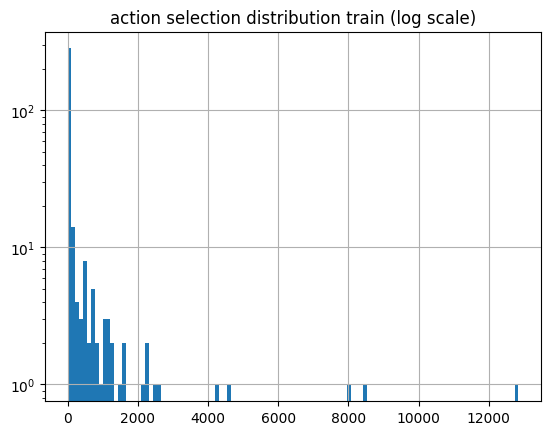

In [124]:
if CREATE_TRAJS:
    action_counts.hist(bins=action_counts.nunique(), log=True)
    plt.title('action selection distribution train (log scale)')
    print("# possible actions: {}".format(len(action_bin_definition)))
    print("actions never chosen: {}".format((action_counts == 0).sum()))
    most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
    print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions.value_counts().max()))

In [239]:
discretized_actions_test.value_counts().max()/ discretized_actions_test.value_counts().sum()

0.16081860865201963

# possible actions: 343
actions never chosen: 170
most chosen action: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7)), chosen 4487 times


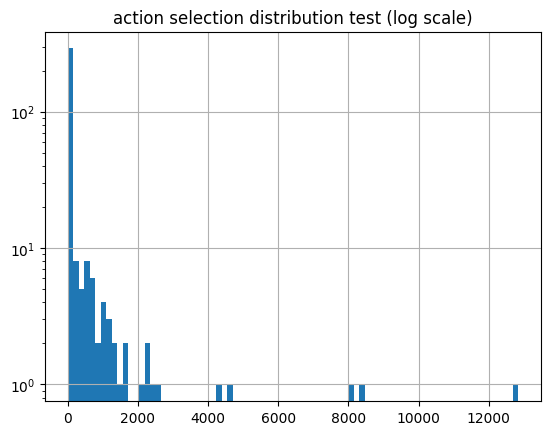

In [125]:
if CREATE_TRAJS:
    observed_action_counts_test = discretized_actions_test.value_counts()
    action_info_test = {}
    action_counts_test = []
    for action_id in range(len(action_bin_definition)):
        count = observed_action_counts_test[action_id] if action_id in observed_action_counts_test else 0
        action_info_test[action_id] = (action_bin_definition, count)
        action_counts_test.append(count)
    action_counts_test = pd.Series(action_counts_test)
    action_counts.hist(bins=action_counts_test.nunique(), log=True)
    plt.title('action selection distribution test (log scale)')
    print("# possible actions: {}".format(len(action_bin_definition)))
    print("actions never chosen: {}".format((action_counts_test == 0).sum()))
    most_chosen_action = action_bin_definition[discretized_actions_test.mode()[0]]
    print("most chosen action: (tv: {}, peep:{}, fio2: {}), chosen {} times".format(*most_chosen_action, discretized_actions_test.value_counts().max()))

In [126]:
if CREATE_TRAJS:
    # state-action pair
    state_actions = list(itertools.product(range(n_states), range(len(action_bin_definition)),))
    print("{} states x {} actions = {} state-action pairs".format(n_states, len(action_bin_definition), len(state_actions)))
    state_action_ids = list(map(lambda x: "{}-{}".format(x[0], x[1]), state_actions))

650 states x 343 actions = 222950 state-action pairs


In [127]:
if CREATE_TRAJS:
    train_set['terminal'] = False
    train_set.loc[train_set.groupby('icustay_id').tail(1).index, 'terminal'] = True

    train_set['state_action_id'] = train_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
    train_set['next_state'] = train_set.state.astype(str).shift(-1)
    # create special terminal states for both outcomes
    terminal_mort = train_set['state'].max() + 1
    terminal_nonmort = train_set['state'].max() + 2

    train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'next_state'] = terminal_mort
    train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'next_state'] = terminal_nonmort

    # State-Action-NextState_ID
    train_set['sans_id'] = train_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
    observed_saction_counts = train_set['state_action_id'].value_counts()
    saction_info = {}
    saction_counts = []
    for i, saction_id in enumerate(state_action_ids):
        count = observed_saction_counts[saction_id] if saction_id in observed_saction_counts else 0
        state, action = saction_id.split('-')
        saction_info[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
        saction_counts.append(count)
    saction_counts = pd.Series(saction_counts)
    # saction_info

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\4036423696.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['terminal'] = False
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\4036423696.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['state_action_id'] = train_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\4036423696.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

In [128]:
if CREATE_TRAJS:
    test_set['state_action_id'] = test_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
    test_set['next_state'] = test_set.state.astype(str).shift(-1)
    # State-Action-NextState_ID
    test_set['sans_id'] = test_set.agg('{0[state_action_id]}-{0[next_state]}'.format, axis=1)
    observed_saction_counts_test = test_set['state_action_id'].value_counts()
    
    
    test_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'next_state'] = terminal_mort
    test_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'next_state'] = terminal_nonmort
    
    saction_info_test = {}
    saction_counts_test = []
    for i, saction_id in enumerate(state_action_ids):
        count = observed_saction_counts_test[saction_id] if saction_id in observed_saction_counts_test else 0
        state, action = saction_id.split('-')
        saction_info_test[saction_id] = (saction_id, i, count, int(state), int(action), action_bin_definition[int(action)], )
        saction_counts_test.append(count)
    saction_counts_test = pd.Series(saction_counts_test)
    # saction_info_test

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\247294981.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['state_action_id'] = test_set.agg('{0[state]}-{0[action_discrete]}'.format, axis=1)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\247294981.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['next_state'] = test_set.state.astype(str).shift(-1)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\247294981.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

In [129]:
if CREATE_TRAJS:
    saction_info_df = pd.DataFrame([[*v,] for k, v in  saction_info.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])
    saction_info_df_test = pd.DataFrame([[*v,] for k, v in  saction_info_test.items()], columns=['saction_id', 'index', 'count', 'state', 'action', 'action'])

In [241]:
saction_info_df

,saction_id,index,count,state,action,action
0,0-0,0,0,0,0,"((0, 2.5), (20, 30), (0, 5))"
1,0-1,1,0,0,1,"((0, 2.5), (20, 30), (5, 7))"
2,0-2,2,0,0,2,"((0, 2.5), (20, 30), (7, 9))"
3,0-3,3,0,0,3,"((0, 2.5), (20, 30), (9, 11))"
4,0-4,4,0,0,4,"((0, 2.5), (20, 30), (11, 13))"
...,...,...,...,...,...,...
222945,649-338,222945,0,649,338,"((15, inf), (55, inf), (7, 9))"
222946,649-339,222946,0,649,339,"((15, inf), (55, inf), (9, 11))"
222947,649-340,222947,0,649,340,"((15, inf), (55, inf), (11, 13))"
222948,649-341,222948,0,649,341,"((15, inf), (55, inf), (13, 15))"


timothy trace code: see the diverse of the action under the same state

243.2740524781341

In [268]:
train_set.columns

Index(['Unnamed: 0', 'icustay_id', 'subject_id', 'hadm_id', 'intime',
       'outtime', 'start_time', 'admission_age', 'gender', 'weight',
       ...
       'traj_count_inv', 'traj_len', 'terminal', 'nterminal', 'reward',
       'compliance', 'potential', 'shaping_reward_unshift', 'shaping_reward',
       'positive_outcome'],
      dtype='object', length=385)

In [293]:
train_set[['state', 'action_discrete', 'next_state']]

,state,action_discrete,next_state
0,143,128,143
1,143,143,25
2,25,169,39
3,39,176,25
4,25,183,130
...,...,...,...
83438,279,190,279
83439,279,190,279
83440,279,190,279
83441,279,141,549


In [276]:
train_set.groupby('sans_id')[['sans_id']].count() > 1

,sans_id
sans_id,
0-122-34,False
0-128-0,False
0-134-0,False
0-134-25,False
0-134-651,False
...,...
99-218-651,False
99-218-99,True
99-225-99,False


In [283]:
sans_id_count = train_set.groupby('sans_id')[['sans_id']].count()
sans_id_count

,sans_id
sans_id,
0-122-34,1
0-128-0,1
0-134-0,1
0-134-25,1
0-134-651,1
...,...
99-218-651,1
99-218-99,26
99-225-99,1


In [295]:
sans_id_count[sans_id_count['sans_id'] > 1]

,sans_id
sans_id,
0-135-0,3
0-135-651,2
0-135-76,2
0-142-0,2
0-170-0,12
...,...
99-169-99,38
99-176-99,3
99-204-99,2


In [297]:
grouped = train_set.groupby('state')

# Prepare a dictionary to hold results
results = {}

# Analyze each group
# for state, group in grouped:
#     print(len(group))
len(grouped)

650

In [308]:
train_set[["state", "action_discrete"]].groupby("state").count().sort_values(by="action_discrete", ascending=False)

,action_discrete
state,
277,394
485,390
343,346
9,344
384,333
...,...
375,10
472,9
330,4


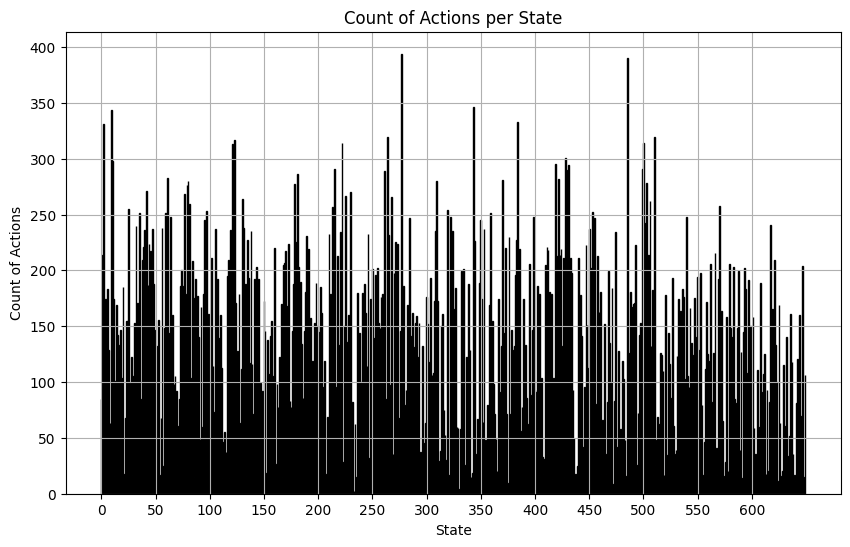

In [311]:
# Count 'action_discrete' per 'state'
counts = train_set[["state", "action_discrete"]].groupby("state").count().reset_index()

# Ensure all states from 0 to 649 are included
all_states = pd.DataFrame({'state': range(650)})
counts = pd.merge(all_states, counts, on='state', how='left').fillna(0)

# Plot using a bar plot
plt.figure(figsize=(10, 6))  # Increase figure size for better visibility
plt.bar(counts['state'], counts['action_discrete'], color='skyblue', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Count of Actions')
plt.title('Count of Actions per State')
plt.xticks(range(0, 650, 50))  # Show state numbers on x-axis at intervals
plt.grid(True)
plt.show()

timothy trace code:
the meaning of 28.14 means on average each state will have 28 different kinds of actions

In [326]:
# Count unique actions per state
unique_actions_per_state = train_set.groupby('state')['action_discrete'].nunique()
unique_actions_per_state_ratio = unique_actions_per_state * (train_set.groupby('state')['action_discrete'].count() / train_set.groupby('state')['action_discrete'].count().sum())
print(f'on average each state will have: {unique_actions_per_state_ratio.sum()} different kinds of actions')
print(f'max for single state will have: {unique_actions_per_state.max()} different kinds of actions')
print(f'min for single state will have: {unique_actions_per_state.min()} different kinds of actions')

unique_next_state_per_state = train_set.groupby('state')['next_state'].nunique()
unique_next_state_per_state_ratio = unique_next_state_per_state * (train_set.groupby('state')['next_state'].count() / train_set.groupby('state')['next_state'].count().sum())
print(f'on average each state will have: {unique_next_state_per_state_ratio.sum()} different kinds of next_state')
print(f'max for single state will have: {unique_next_state_per_state.max()} different kinds of next_state')
print(f'min for single state will have: {unique_next_state_per_state.min()} different kinds of next_state')

on average each state will have: 28.413875340052492 different kinds of actions
max for single state will have: 50 different kinds of actions
min for single state will have: 1 different kinds of actions
on average each state will have: 44.7103292067639 different kinds of next_state
max for single state will have: 144 different kinds of next_state
min for single state will have: 2 different kinds of next_state


In [294]:
""" # Group by state
grouped = train_set.groupby('state')

# Prepare a dictionary to hold results
results = {}

# Analyze each group
for state, group in grouped:
    result = {
        'same_action_same_next_state': 0,
        'same_action_diff_next_state': 0,
        'diff_action_same_next_state': 0,
        'diff_action_diff_next_state': 0
    }
    
    # Compare each pair of rows in the group
    for i in range(len(group)):
        for j in range(i + 1, len(group)):
            action_i = group.iloc[i]['action_discrete']
            next_state_i = group.iloc[i]['next_state']
            action_j = group.iloc[j]['action_discrete']
            next_state_j = group.iloc[j]['next_state']
            
            if action_i == action_j and next_state_i == next_state_j:
                result['same_action_same_next_state'] += 1
            elif action_i == action_j and next_state_i != next_state_j:
                result['same_action_diff_next_state'] += 1
            elif action_i != action_j and next_state_i == next_state_j:
                result['diff_action_same_next_state'] += 1
            elif action_i != action_j and next_state_i != next_state_j:
                result['diff_action_diff_next_state'] += 1
    
    results[state] = result

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T

print(results_df) """

KeyboardInterrupt: 

# state-action pairs: 222950
# state-action pairs never visited: 207762
most visited state-action pair in train: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7), state: 9), visited 153 times


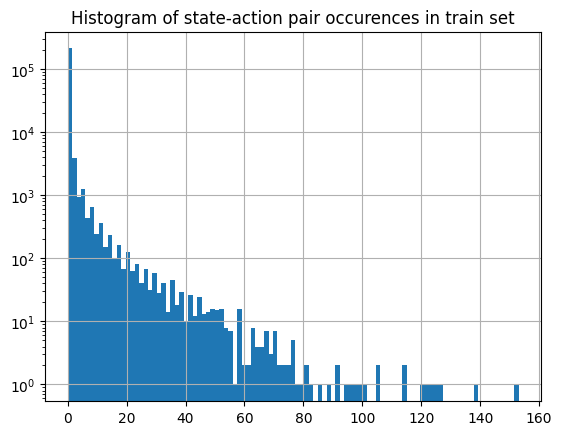

In [130]:
if CREATE_TRAJS:
    print("# state-action pairs: {}".format(len(state_action_ids)))
    print("# state-action pairs never visited: {}".format((saction_counts == 0).sum()))
    most_frequent_saction = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
    most_chosen_action = action_bin_definition[discretized_actions.mode()[0]]
    saction_counts.hist(bins=saction_counts.nunique(), log=True)
    plt.title("Histogram of state-action pair occurences in train set")
    print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action, most_frequent_saction[3], most_frequent_saction[2]))

most visited state-action pair in train: (tv: (7.5, 10), peep:(40, 45), fio2: (5, 7), state: 9), visited 153 times


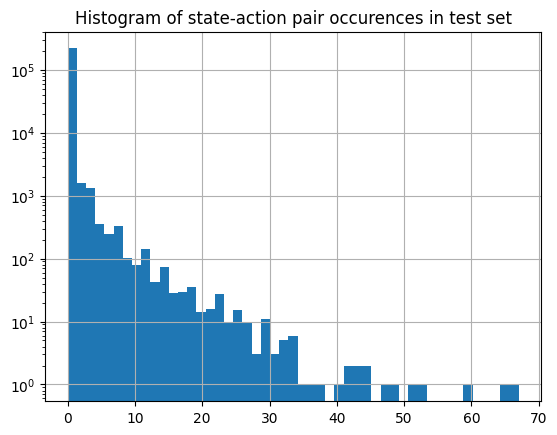

In [131]:
if CREATE_TRAJS:
    most_frequent_saction_test = saction_info_df[saction_info_df.index == saction_counts.argmax()].to_numpy()[0]
    most_chosen_action_test = action_bin_definition[discretized_actions.mode()[0]]
    saction_counts_test.hist(bins=saction_counts_test.nunique(), log=True)
    plt.title("Histogram of state-action pair occurences in test set")
    print("most visited state-action pair in train: (tv: {}, peep:{}, fio2: {}, state: {}), visited {} times".format(*most_chosen_action_test, most_frequent_saction_test[3], most_frequent_saction_test[2]))

In [132]:
if not CREATE_TRAJS:
    test_set = pd.read_csv('data/test_{}_traj_{}.csv'.format(shaping_name, seed))
    train_set = pd.read_csv('data/train_{}_traj_{}.csv'.format(shaping_name, seed))

## Trajectory construction

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3047370848.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['traj_count'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3047370848.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['traj_count_inv'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3047370848.py:3: 

count    5272.000000
mean       15.827580
std         3.371015
min         7.000000
25%        13.750000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

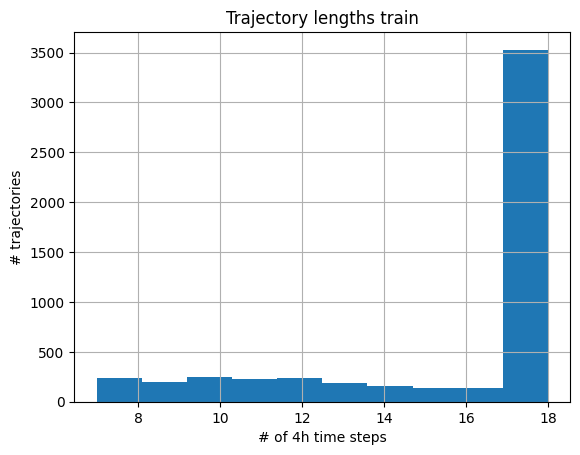

In [133]:
train_set['traj_count'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
train_set['traj_count_inv'] = train_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
train_set['traj_len'] = train_set.groupby('icustay_id')['traj_count'].transform('max')
train_set['traj_len'] += 1

trajectory_lengths = train_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths.hist()
plt.title('Trajectory lengths train')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths.describe()

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\2594484659.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['traj_count'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\2594484659.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['traj_count_inv'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\2594484659.py:3: Perf

count    1754.000000
mean       15.907070
std         3.331799
min         7.000000
25%        14.000000
50%        18.000000
75%        18.000000
max        18.000000
Name: traj_count, dtype: float64

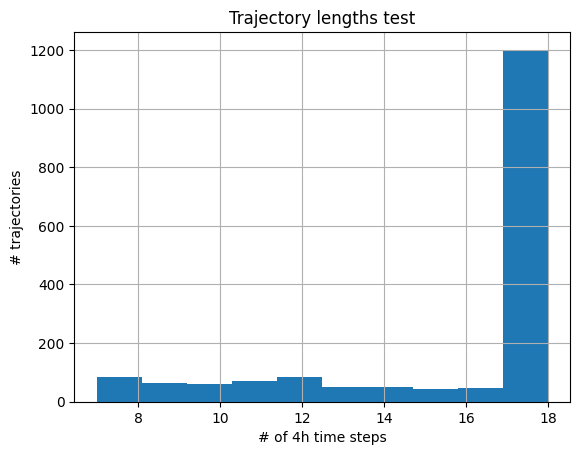

In [134]:
test_set['traj_count'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount()
test_set['traj_count_inv'] = test_set.sort_values(['icustay_id', 'start_time']).groupby('icustay_id').cumcount(ascending=False)
test_set['traj_len'] = test_set.groupby('icustay_id')['traj_count'].transform('max')
test_set['traj_len'] += 1

trajectory_lengths_test = test_set.groupby('icustay_id').traj_count.max() + 1
trajectory_lengths_test.hist()
plt.title('Trajectory lengths test')
plt.xlabel('# of 4h time steps')
plt.ylabel('# trajectories')
trajectory_lengths_test.describe()

In [135]:
terminals = train_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in train_set.columns:
    # need to remove this column if it already exists
    del(train_set['terminal'])
train_set = train_set.join(terminals, on='Unnamed: 0', how='left')
train_set['terminal'] = train_set.terminal.fillna(False)
train_set['nterminal'] = train_set.terminal.shift(-1).fillna(False)

terminals = test_set.groupby('icustay_id').max('traj_count').reset_index().set_index('Unnamed: 0')['traj_count']
terminals = (~terminals.isna()).rename('terminal')
if 'terminal' in test_set.columns:
    # need to remove this column if it already exists
    del(test_set['terminal'])
test_set = test_set.join(terminals, on='Unnamed: 0', how='left')
test_set['terminal'] = test_set.terminal.fillna(False)
test_set['nterminal'] = test_set.terminal.shift(-1).fillna(False)

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\4086799166.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['nterminal'] = train_set.terminal.shift(-1).fillna(False)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\4086799166.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['nterminal'] = test_set.terminal.shift(-1).fillna(False)


In [136]:
assert train_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().max() == 1, "Every icustay should have exactly 1 terminal state"
assert train_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"
assert test_set.groupby('icustay_id').terminal.sum().min() == 1, "Every icustay should have exactly 1 terminal state"

In [330]:
train_set

,Unnamed: 0,icustay_id,subject_id,hadm_id,intime,outtime,start_time,admission_age,gender,weight,adult_ibw,icu_readmission,elixhauser_vanwalraven,sofa,sirs,gcs,heartrate,sysbp,diasbp,meanbp,shockindex,resprate,tempc,spo2,potassium,sodium,chloride,glucose,bun,creatinine,magnesium,calcium,ionizedcalcium,carbondioxide,sgot,sgpt,bilirubin,albumin,hemoglobin,wbc,platelet,ptt,pt,inr,ph,pao2,paco2,base_excess,bicarbonate,lactate,pao2fio2ratio,mechvent,fio2,urineoutput,vaso_total,iv_total,cum_fluid_balance,peep,tidal_volume,volume_controlled,plateau_pressure,hospmort,mort90day,dischtime,deathtime,hadmittime,hdischtime,height,vent_num,vent_duration_h,vent_num_imp,vent_imp_step,vent_shift,select_peine,select_peine_step,select_peine_step_rev,start_time_icustay,los_icu,hadm_duration,mort,sofa_imp,sirs_imp,gcs_imp,heartrate_imp,sysbp_imp,meanbp_imp,diasbp_imp,shockindex_imp,resprate_imp,spo2_imp,tempc_imp,potassium_imp,sodium_imp,chloride_imp,glucose_imp,bun_imp,creatinine_imp,magnesium_imp,calcium_imp,ionizedcalcium_imp,carbondioxide_imp,bilirubin_imp,albumin_imp,hemoglobin_imp,wbc_imp,platelet_imp,ptt_imp,pt_imp,inr_imp,ph_imp,pao2_imp,paco2_imp,base_excess_imp,bicarbonate_imp,lactate_imp,pao2fio2ratio_imp,iv_total_imp,vaso_total_imp,urineoutput_imp,cum_fluid_balance_imp,peep_imp,fio2_imp,tidal_volume_imp,plateau_pressure_imp,sofa_in_tukeys_fence,sirs_in_tukeys_fence,gcs_in_tukeys_fence,heartrate_in_tukeys_fence,sysbp_in_tukeys_fence,meanbp_in_tukeys_fence,diasbp_in_tukeys_fence,shockindex_in_tukeys_fence,resprate_in_tukeys_fence,spo2_in_tukeys_fence,tempc_in_tukeys_fence,potassium_in_tukeys_fence,sodium_in_tukeys_fence,chloride_in_tukeys_fence,glucose_in_tukeys_fence,bun_in_tukeys_fence,creatinine_in_tukeys_fence,magnesium_in_tukeys_fence,calcium_in_tukeys_fence,ionizedcalcium_in_tukeys_fence,carbondioxide_in_tukeys_fence,bilirubin_in_tukeys_fence,albumin_in_tukeys_fence,hemoglobin_in_tukeys_fence,wbc_in_tukeys_fence,platelet_in_tukeys_fence,ptt_in_tukeys_fence,pt_in_tukeys_fence,inr_in_tukeys_fence,ph_in_tukeys_fence,pao2_in_tukeys_fence,paco2_in_tukeys_fence,base_excess_in_tukeys_fence,bicarbonate_in_tukeys_fence,lactate_in_tukeys_fence,pao2fio2ratio_in_tukeys_fence,iv_total_in_tukeys_fence,vaso_total_in_tukeys_fence,urineoutput_in_tukeys_fence,cum_fluid_balance_in_tukeys_fence,peep_in_tukeys_fence,fio2_in_tukeys_fence,tidal_volume_in_tukeys_fence,plateau_pressure_in_tukeys_fence,sofa_imp_scaled,sirs_imp_scaled,gcs_imp_scaled,heartrate_imp_scaled,sysbp_imp_scaled,meanbp_imp_scaled,diasbp_imp_scaled,shockindex_imp_scaled,resprate_imp_scaled,spo2_imp_scaled,tempc_imp_scaled,potassium_imp_scaled,sodium_imp_scaled,chloride_imp_scaled,glucose_imp_scaled,bun_imp_scaled,creatinine_imp_scaled,magnesium_imp_scaled,calcium_imp_scaled,ionizedcalcium_imp_scaled,carbondioxide_imp_scaled,bilirubin_imp_scaled,albumin_imp_scaled,hemoglobin_imp_scaled,wbc_imp_scaled,platelet_imp_scaled,ptt_imp_scaled,pt_imp_scaled,inr_imp_scaled,ph_imp_scaled,pao2_imp_scaled,paco2_imp_scaled,base_excess_imp_scaled,bicarbonate_imp_scaled,lactate_imp_scaled,pao2fio2ratio_imp_scaled,iv_total_imp_scaled,vaso_total_imp_scaled,urineoutput_imp_scaled,cum_fluid_balance_imp_scaled,peep_imp_scaled,fio2_imp_scaled,tidal_volume_imp_scaled,plateau_pressure_imp_scaled,admission_age_scaled,adult_ibw_scaled,height_scaled,weight_scaled,elixhauser_vanwalraven_scaled,vent_duration_h_scaled,sofa_imp_scaled_impknn,sirs_imp_scaled_impknn,gcs_imp_scaled_impknn,heartrate_imp_scaled_impknn,sysbp_imp_scaled_impknn,meanbp_imp_scaled_impknn,diasbp_imp_scaled_impknn,shockindex_imp_scaled_impknn,resprate_imp_scaled_impknn,spo2_imp_scaled_impknn,tempc_imp_scaled_impknn,potassium_imp_scaled_impknn,sodium_imp_scaled_impknn,chloride_imp_scaled_impknn,glucose_imp_scaled_impknn,bun_imp_scaled_impknn,creatinine_imp_scaled_impknn,magnesium_imp_scaled_impknn,calcium_imp_scaled_impknn,ionizedcalcium_imp_scaled_impknn,carbondioxide_imp_scaled_impknn,bilirubin_imp_scaled_impknn,albumin_imp_scaled_impknn,hemogl

In [137]:
# generate s,s',a tuples for transition matrix approximation
  
# calculate joint state-action probabilities
pr_state_action = pd.DataFrame((train_set.state_action_id.value_counts() / train_set.shape[0])).reset_index().rename(columns={'state_action_id': 'sa_id', 'count': 'pr_sa'})


# calculate joint s-s'-a probabilities
sans_id = '' # state-action-nstate id
pr_nstate_state_action = pd.DataFrame(train_set.sans_id.value_counts() / train_set.shape[0]).reset_index().rename(columns={'index': 'sans_id', 'count': 'pr_sans'})
pr_nstate_state_action['sa_id'] = list(map(lambda x: '-'.join(x[:2]), pr_nstate_state_action.sans_id.str.split('-')))
pr_sans = pr_nstate_state_action.merge(pr_state_action, on='sa_id', how='inner').set_index('sans_id')

# calculate transition probabilities
pr_trans = pr_sans.pr_sans / pr_sans.pr_sa
pr_trans = pd.DataFrame(pr_trans).rename(columns={0: 'pr_t'})



In [342]:
print(f'sans appear single time count: {len(train_set.sans_id.value_counts()[train_set.sans_id.value_counts() == 1])}')
print(f'sans appear single time ratio: {len(train_set.sans_id.value_counts()[train_set.sans_id.value_counts() == 1]) / len(train_set.sans_id.value_counts())}')

sans appear single time count: 32561
sans appear single time ratio: 0.7712952435095698


In [335]:
train_set.shape

(83443, 386)

In [334]:
pr_trans

,sans_id,pr_t,state,action,nstate
0,9-169-9,0.549020,9,169,9
1,9-169-651,0.045752,9,169,651
2,9-169-181,0.039216,9,169,181
3,9-169-506,0.032680,9,169,506
4,9-169-42,0.032680,9,169,42
...,...,...,...,...,...
42211,578-233-203,1.000000,578,233,203
42212,503-85-265,1.000000,503,85,265
42213,210-92-210,1.000000,210,92,210
42214,1-191-172,1.000000,1,191,172


Text(0.5, 1.0, 'Distribution of nonzero transition probabilities')

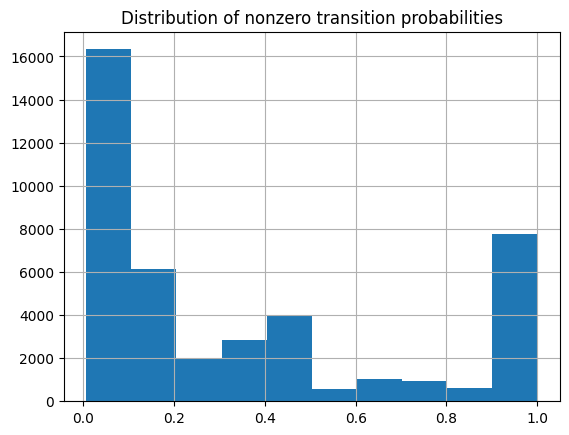

In [138]:
pr_trans.pr_t.hist()
pr_trans
plt.title('Distribution of nonzero transition probabilities')

In [139]:
split_sans = pd.DataFrame(pr_trans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_sans.state = split_sans.state.astype(int)
split_sans.action = split_sans.action.astype(int)
split_sans.nstate = split_sans.nstate.astype(int)
assert split_sans.action.max() <= (7**3 - 1), "the highest action id exceeds the number of actions" # number of discrete actions
pr_trans = pr_trans.reset_index().merge(split_sans, left_index=True, right_index=True)

In [140]:
# all transition probabilities for a state-action pair should sum to 1, there could be some rounding errors
print("{:.5f}% of state-action's probs does not sum to 1, max diff to 1 is {}".format(
    (~(pr_trans.groupby(['state', 'action']).pr_t.sum() >= 1.0)).to_numpy().mean(),
    np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max(),
))
assert np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max() < 1e-15, "transition probabilities for a state-action pair should sum (approx.) to 1"

0.05030% of state-action's probs does not sum to 1, max diff to 1 is 3.3306690738754696e-16


In [141]:
np.diff(pr_trans.groupby(['state', 'action']).pr_t.sum(), 1).max()

3.3306690738754696e-16

Text(0.5, 1.0, 'Histogram of nonzero transition probabilities')

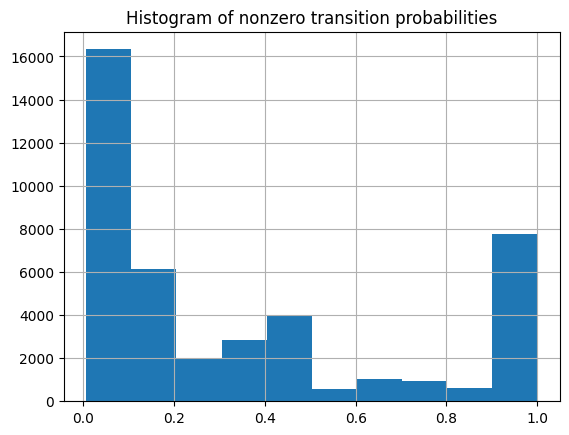

In [142]:
pr_trans.pr_t.hist()
plt.title('Histogram of nonzero transition probabilities')

## Immediate reward definition

In [143]:
def compliance_to_potential(compliance):
    return compliance * COMPLIANCE_SCALAR

def potential_diff(x):
    if np.isnan(x.iloc[1]):
        p1 = 0.0 # see Grzes, AAMAS 2017
    else:
        p1 = GAMMA * x.iloc[1]
    return p1 - x.iloc[0]

train_set['reward'] = 0
test_set['reward'] = 0
train_set.loc[train_set.terminal & (train_set.mort90day == 't'), 'reward'] = -100
test_set.loc[test_set.terminal & (test_set.mort90day == 't'), 'reward'] = -100
train_set.loc[train_set.terminal & (train_set.mort90day == 'f'), 'reward'] = 100
test_set.loc[test_set.terminal & (test_set.mort90day == 'f'), 'reward'] = 100


assert train_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert test_set.reward.isna().sum() == 0, "All immediate rewards should be set"
assert train_set[train_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"
assert test_set[test_set.terminal].reward.isin({-100, 100}).all(), "Transitions to terminal states should have value -100 or 100"

if SHAPING:
    # TODO FdH: implement shaping
    if SHAPING == 'avgpotential2':
        train_set['compliance'] = safety.state_compliance_clinical(train_set, safety.avg_clinical_timestep)
    elif SHAPING == 'allpotential':
        train_set['compliance'] = safety.state_compliance_clinical(train_set, safety.all_clinical_timestep)
    else:
        raise ValueError('Unknown shaping approach')
    train_set['potential'] = compliance_to_potential(train_set['compliance'])
    if 'potential' in SHAPING:
        train_set['shaping_reward_unshift'] = train_set.groupby('icustay_id').rolling(window=2)['potential'].apply(potential_diff).fillna(0.0).reset_index().set_index('level_1')['potential']
        train_set['shaping_reward'] = train_set['shaping_reward_unshift'].shift(-1)
        train_set.loc[train_set.terminal, 'shaping_reward'] = train_set['potential']
    elif 'base' in SHAPING:
        train_set['shaping_reward'] = train_set['potential']
    
    train_set['reward'] = train_set.reward + train_set.shaping_reward

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1433179484.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['reward'] = 0
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1433179484.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['reward'] = 0
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1433179484.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using p

reward
 0.0      38062
 100.0     2576
-100.0     1578
Name: count, dtype: int64

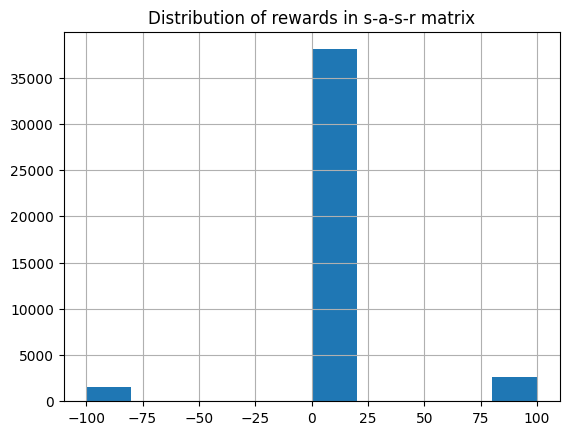

In [144]:
# 1. compute average immediate reward for each s-s'-a with support from the data.
# 2. where -100 if terminal and 90 day mortality, +100 if terminal and 90 day mortality, 0 otherwise
# 3. element-wise multiply with transition matrix pr_trans
# 4. sum over s' dimension to obtain R(s, a) < sum because transition matrix has probabilities

# step 1: compute average immediate reward for each s-s'-a with support from the data.
r_sans = train_set.groupby('sans_id')['reward'].mean()
r_sans.hist()
plt.title('Distribution of rewards in s-a-s-r matrix')
split_r_sans = pd.DataFrame(r_sans.index.str.split('-').tolist()).rename(columns={0:'state', 1: 'action', 2: 'nstate'})
split_r_sans.state = split_r_sans.state.astype(int)
split_r_sans.action = split_r_sans.action.astype(int)
split_r_sans.nstate = split_r_sans.nstate
r_sans = r_sans.reset_index().merge(split_r_sans, left_index=True, right_index=True)
r_sans.reward.value_counts()

In [145]:
pr_r_sans = r_sans.merge(pr_trans, on='sans_id')
assert pr_r_sans.pr_t.isna().sum() == 0, "transition probabilities should never be na"
assert pr_r_sans.reward.isna().sum() == 0, "rewards should never be na"
assert pr_r_sans.shape[0] == r_sans.shape[0], "all reward rows should be in transition-reward dataframe"
assert pr_r_sans.shape[0] == pr_sans.shape[0], "all transition rows should be in transition-reward dataframe"
assert pr_r_sans.sans_id.value_counts().max() == 1, "a s-a-r-s tuple should occur exactly once"
assert pr_r_sans.sans_id.value_counts().min() == 1, "a s-a-r-s tuple should occur exactly once"

In [146]:
# step 3: element-wise multiply with transition matrix pr_trans
pr_r_sans['weighted_reward'] = pr_r_sans.reward * pr_r_sans.pr_t
immediate_reward = pr_r_sans.groupby(['state_x', 'action_x']).weighted_reward.sum()
immediate_reward = immediate_reward.reset_index().rename(columns={'state_x': 'state', 'action_x': 'action', 'weighted_reward': 'immediate_reward'})

immediate_reward
 0.000000      11704
 100.000000      382
 50.000000       250
 33.333333       202
-100.000000      191
               ...  
 5.084746          1
-1.923077          1
-1.428571          1
 7.462687          1
-4.545455          1
Name: count, Length: 278, dtype: int64

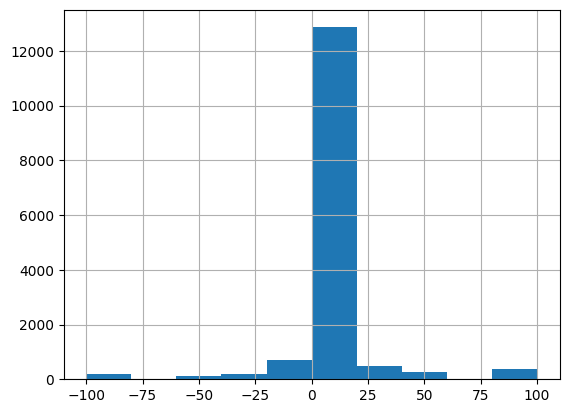

In [147]:
immediate_reward.immediate_reward.hist()
immediate_reward.immediate_reward.value_counts()

In [148]:
immediate_reward['state_action_id'] = immediate_reward.agg('{0[state]:.0f}-{0[action]:.0f}'.format, axis=1)

In [149]:
pr_trans[(pr_trans.state==0) & (pr_trans.action == 71)]

,sans_id,pr_t,state,action,nstate


In [150]:
pr_sans[pr_sans.sa_id=='0-71']['pr_sa']

Series([], Name: pr_sa, dtype: float64)

In [151]:
0.000332 * train_set.shape[0]

27.703076

In [152]:
pr_nstate_state_action.sans_id

0            9-169-9
1        264-169-264
2          61-169-61
3        123-169-123
4        222-169-222
            ...     
42211    500-183-323
42212    500-190-500
42213    189-190-500
42214     45-190-189
42215    279-141-549
Name: sans_id, Length: 42216, dtype: object

In [153]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,9-169-9,0.001007,9-169
1,264-169-264,0.000803,264-169
2,61-169-61,0.000803,61-169
3,123-169-123,0.000791,123-169
4,222-169-222,0.000791,222-169
...,...,...,...
42211,500-183-323,0.000012,500-183
42212,500-190-500,0.000012,500-190
42213,189-190-500,0.000012,189-190
42214,45-190-189,0.000012,45-190


In [154]:
pr_nstate_state_action

,sans_id,pr_sans,sa_id
0,9-169-9,0.001007,9-169
1,264-169-264,0.000803,264-169
2,61-169-61,0.000803,61-169
3,123-169-123,0.000791,123-169
4,222-169-222,0.000791,222-169
...,...,...,...
42211,500-183-323,0.000012,500-183
42212,500-190-500,0.000012,500-190
42213,189-190-500,0.000012,189-190
42214,45-190-189,0.000012,45-190


In [155]:
(train_set.icustay_id == 299994).any()

False

In [156]:
if shaping_name == 'unshaped':
    test_set.to_csv('../mimic-data/test_{}_traj_{}.csv'.format(shaping_name, seed))
    train_set.to_csv('../mimic-data/train_{}_traj_{}.csv'.format(shaping_name, seed))

In [157]:
safety.action_compliance_clinical(train_set).mean()

0.5519815922246324

In [158]:
safety.state_compliance_clinical(train_set, safety.avg_clinical_timestep).mean()

0.9719658928849634

# Training a policy

In [159]:
immediate_reward[['state', 'action', 'immediate_reward']]
# matrix of immediate rewards
sar = np.full((n_states, 7**3), np.nan)
for state, action, reward in immediate_reward[['state', 'action', 'immediate_reward']].to_numpy():
    sar[int(state), int(action)] = reward

# Qn = {} # maps n to q tables

In [346]:
sar.shape

(650, 343)

In [160]:
# According to the tabular FQI algorithm in Ernst, Geurts & Wehenkel (2005), Figure 1
# and Peine's supplementary discussion "A: Evaluation of Policies".
def peine_mc_iterate(snsasr, r, Qn, gamma, n_epochs=1, learning_rate=0.1, unsafety_prob=0.0, safety_map=safety.action_id_compliance):
    """
    Monte-carlo-based iteration of the training procedure according to tabular FQI & Peine's supplementary discussion.
    
    snsas: numpy ndarray with discretized state-nextstate-action tuples
    r: a function that returns the immediate reward for a state-action pair
    Qn: dictionary that maps iteration indices to Qn-estimates
    n: iteration number
    gamma: discount factor
    n_epochs: number of times to iterate over dataset
    learning rate: learning rate alpha
    """
    def epoch(snsasr, r, Qn, gamma, learning_rate, unsafety_prob, safety_map):
        for i, (s, ns, a, er) in enumerate(snsasr):
            if unsafety_prob == 1.0:
                # We do not care about the safety rules
                Qn[s,a] = Qn[s,a] + learning_rate * (er + gamma * np.max(Qn[int(ns),:]) - Qn[s,a])
            elif unsafety_prob == 0.0:
                if safety_map[a]:
                    Qn[s,a] = Qn[s,a] + learning_rate * (er + gamma * np.max(Qn[int(ns), safety_map]) - Qn[s,a])
                else:
                    # taken action not safe, disregard sample
                    pass
            else:
                raise ValueError("Only unsafety probs in {0.0, 1.0} supported for now")
                #TODO FdH: implement unsafety probs (0.0, 0.0}
        return Qn
    assert Qn.shape == (n_states+2, 7**3)
    assert safety_map is not None or unsafety_prob == 0.0
    for n in range(n_epochs):
        Qn = epoch(snsasr, r, Qn, gamma, learning_rate, unsafety_prob, safety_map)
        assert np.nanmax(Qn) < 100, "Scores > 100 should not occur, found: {}".format(np.nanargmax(Qn))
        print('.', end='')
    return Qn


def ernst_iterate(snsasr, Qn, n, gamma, regressor, action_space, state_repr=None, action_repr=utils.to_discrete_action_bins):
    """
    snsas: numpy ndarray with discretized state_id-nextstate_id-action_id tuples
    r: immediate rewards
    Qn: dictionary that maps iteration indices to Qn estimates/estimators
    n: iteration number
    gamma: discount factor
    regression: sklearn regression class
    action_space: iterator that retuns all actions in
    action_repr: function that returns the action representation
    """
    def batches(X, batch_size):
        n_batches = int(math.ceil(X.shape[0] / batch_size))
        batches = []
        for i in range(n_batches):
            batch_start = i * batch_size
            batch_end = min(batch_start + batch_size, X.shape[0])
            batches.append((batch_start, batch_end))
        return batches

    def prediction_set(X, action_space):
        shape_x = X.shape
        n_actions = action_space.shape[0]
        action_dims = action_space.shape[1]
        repeated_X = X.repeat(n_actions, axis=0).reshape((shape_x[0] * n_actions, shape_x[1]))
        repeated_action_reprs = np.tile(action_space, (shape_x[0], 1)).reshape(repeated_X.shape[0], action_dims)
        return np.concatenate([repeated_X, repeated_action_reprs], axis=1)

    Q_hat = Qn[n]
    n = n + 1
    # terminal states only
    snsasr_t = snsasr[snsasr[:,1] >= 650] # 650 = number of non-terminal states
    r_t = snsasr_t[:, 3]
    # non-terminal states only
    snsasr = snsasr[snsasr[:,1] < 650] # 650 = number of non-terminal states
    a_reprs = np.array(list(map(action_repr, snsasr[:,2])))
    action_space_reprs = np.array(list(map(action_repr, action_space)))
    s_reprs = state_repr.transform(snsasr[:, 0].reshape(-1, 1))
    ns_reprs = state_repr.transform(snsasr[:, 1].reshape(-1, 1))
    r = snsasr[:, 3]
    X_train = hstack((s_reprs, a_reprs))
    # generate prediction dataset of length X.shape[0] * len(action_space)
    batch_size = int(X_train.shape[0] / 100)
    y_train = np.array([])
    for batch_start, batch_end in batches(X_train, batch_size):
        X_batch = ns_reprs[batch_start:batch_end, :].toarray()
        X_preds = prediction_set(X_batch, action_space_reprs)
        # predict Q scores for prediction dataset
        y_preds = Q_hat.predict(X_preds)
        # create targets with immediate reward and highest Q score for each row
        y_preds = y_preds.reshape(X_batch.shape[0], len(action_space_reprs))
        y_train = np.concatenate([y_train, r[batch_start:batch_end] + gamma * y_preds.max(axis=1)], axis=0)
        print('.', end ='')
    # terminal states
    a_reprs_t = np.array(list(map(action_repr, snsasr_t[:,2])))
    s_reprs_t = state_repr.transform(snsasr_t[:, 0].reshape(-1, 1))
    X_train_t = hstack((s_reprs_t, a_reprs_t))
    y_train_t = r_t
    print("y_train_t {}".format(y_train_t.shape))
    X_train_n = vstack((X_train_t, X_train))
    print("y_train {}".format(y_train.shape))
    y_train = np.concatenate((y_train, y_train_t))
    print("y_train {}".format(y_train.shape))
    print("X_train_n {}".format(X_train_n.shape))
    Q_hat_new = regressor()
    Q_hat_new.fit(X_train_n, y_train)
    return n, Q_hat_new


# TODO
# implement a regressor that wraps an OLS regressor in the following way:
#  1. creates an OLS regressor for each state
#  2. implements a predict() function that first looks up the right state OLS
#     and then calls predict() on the regressor there with the action levels as input
#  3. implements a fit() function that first segments X into buckets with the same state-action pair
#     then creates a regressor for that pair
#     and calls fit() on that pair << TODO: BUT GIVEN WHAT INPUT? does this only work for a three-dimensional action input?
class PerStateActionOLS():
    def __init__(self, states, default=None):
        self.regressors = {
            state: LinearRegression() for state in states
        }
        self.default = default
        
    def fit(self, X, y, states):
        """
        Fits a set of 
        """
        assert len(X) == len(states) == len(y), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        X_df.loc[:, 'y'] = y
        groups = X_df.groupby('state')
        for k in groups.groups.keys():
            X_group = groups.get_group(k)[X_cols].to_numpy()
            y_group = groups.get_group(k)['y'].to_numpy()
            self.regressors[k].fit(X_group, y_group)
    
    def predict(self, X, states):
        def predict_single(row, X_cols):
            if row.state in self.regressors.keys():
                return self.regressors[row.state].predict(row[X_cols].to_numpy().reshape(1,-1))
            else:
                if self.default is None:
                    raise ValueError('Cannot predict for state {} without default prediction.'.format(row.state))
                else:
                    return self.default
            
        if isinstance(X, Iterable):
            assert len(X) == len(states), "Number of train samples, labels and states should be equal"
        X = np.array(X)
        X_df = pd.DataFrame(X, columns=['X_{}'.format(i) for i in range(X.shape[1])])
        X_cols = list(X_df.columns)
        X_df.loc[:, 'state'] = states
        predictions = X_df.apply(lambda x: predict_single(x, X_cols), axis=1)
        return predictions

class OneHotStateActionOLS():
    def __init__(self, obs_states, all_states=range(650), *args, **kwargs):
        # TODO: ensure that all states are passed
        if type(obs_states) == set:
            obs_states = list(obs_states)
        obs_states = np.array(obs_states).reshape(-1, 1)
        self.state_encoder = OneHotEncoder(categories=[all_states,]).fit(obs_states)
        self.regressor = LinearRegression()
    
    def encode(self, X, states):
        state_encoding = self.state_encoder.transform(states)
        return np.concatenate((X, state_encoding.todense()), axis=1)

    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        X = np.array(X)
        states = np.array(states).reshape(-1, 1)
        X_new = self.encode(X, states)
        return self.regressor.predict(X_new)


class DummyRegressor:
    def __init__(self, return_val=0):
        self.return_val = return_val
        
    def predict(self, X, *args, **kwargs):
        return np.repeat([self.return_val], X.shape[0]).reshape(-1, 1)

In [161]:
q_file = 'models/peine_mc_{}_{}_q_table_{}.bin'.format(shaping_name, UNSAFETY_PROB, seed)
if os.path.isfile(q_file):
    q_dumped = joblib.load(q_file)
    q_mcp_nan = q_dumped['model']
    q_mcp_loaded = True
else:
    q_mcp_loaded = False

In [162]:
0.01 * 10000

100.0

In [163]:
force_training = False # TODO: remember to modify


trace code

In [164]:
pd.set_option('display.max_columns', None)

In [205]:
# train_set.head()
# train_set[['reward']][train_set['reward'] != 0]
# train_set.groupby('reward').size()
# train_set.groupby('icustay_id').size().max() # len(traj).min: 7, max: 18
# train_set.groupby('icustay_id').size().mean() # len(traj).mean() == 15.82757966616085
train_set[['icustay_id', 'state', 'next_state', 'action_discrete', 'reward']][:20]

,icustay_id,state,next_state,action_discrete,reward
0,200003,143,143,128,0.0
1,200003,143,25,143,0.0
2,200003,25,39,169,0.0
3,200003,39,25,176,0.0
4,200003,25,130,183,0.0
5,200003,130,33,134,0.0
6,200003,33,33,171,0.0
7,200003,33,33,178,0.0
8,200003,33,45,171,0.0
9,200003,45,45,169,0.0


2024/04/08 run time: 71 mins

In [166]:
force_training = False
# force_training = True # TODO
if not q_mcp_loaded or force_training:
    q_init_val = 0
    q_init = np.full((n_states + 2, 7**3), float(q_init_val))
    #  peine_mc_iterate(snsas, r, Qn, gamma, n_epochs=1, learning_rate=0.1):
    q_mcp = peine_mc_iterate(
        # TODO: why are the NaNs here? how to deal with these?
        snsasr=train_set[['state', 'next_state', 'action_discrete', 'reward']].astype(int).to_numpy(),
        r=sar,
        Qn=q_init,
        gamma=GAMMA,
        n_epochs=10000,
        learning_rate=0.01,
        unsafety_prob=UNSAFETY_PROB,
        safety_map=safety.action_id_compliance
    )


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

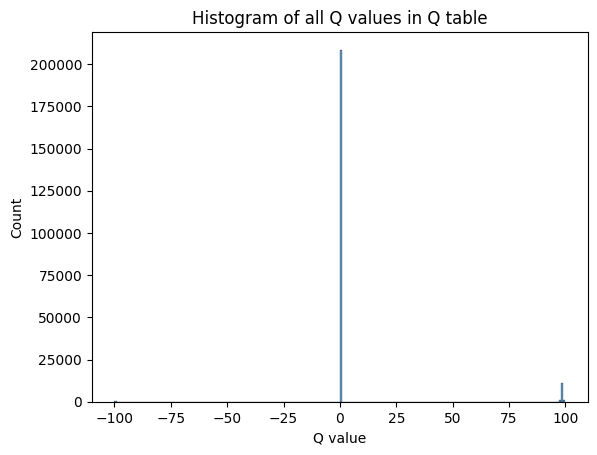

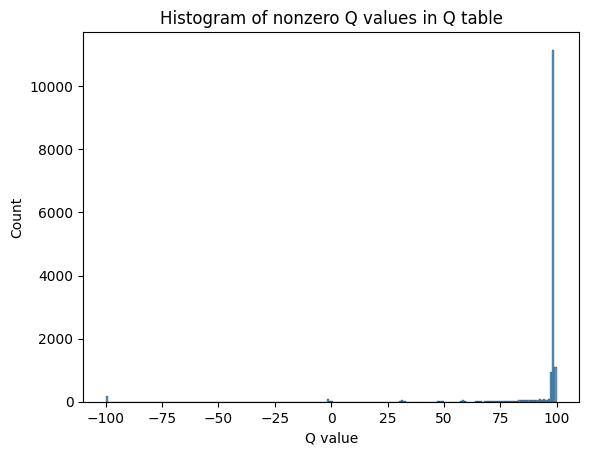

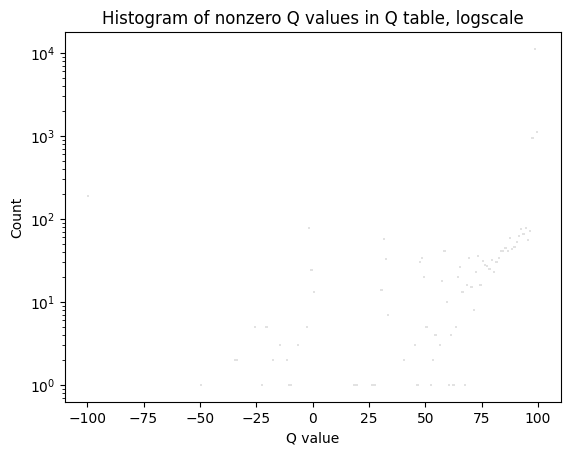

In [167]:
if not q_mcp_loaded or force_training:
    q_mcp_nan = q_mcp.copy()[:n_states, :]
    q_mcp_nan[q_mcp_nan == 0.0] = np.nan
else:
    q_mcp = np.nan_to_num(q_mcp_nan, 0.0)
sns.histplot(q_mcp.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of all Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table')
plt.show()
sns.histplot(q_mcp_nan.ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of nonzero Q values in Q table, logscale')
plt.show()

In [168]:
if not q_mcp_loaded:
    joblib.dump(
        {'hyperparameters': {
            'Q_init': q_init,
            'gamma': GAMMA,
            'n_epochs': 10000,
            'learning_rate': 0.01,
            'shaping': SHAPING,
            'shaping_scalar': COMPLIANCE_SCALAR,
            'unsafety_prob':UNSAFETY_PROB,
            'safety_map':safety.action_id_compliance            
        },
        'model': q_mcp_nan,
        },
        'models/peine_mc_{}_{}_q_table_{}.bin'.format(shaping_name, UNSAFETY_PROB, seed),
        compress=True
    )

In [169]:
# derive policy by taking argmax over non-nan q values
# policy_mcp = np.full()
q_mcp_nan[np.isnan(q_mcp_nan).all(axis=1),:] = 0

best_action_indices = np.nanargmax(q_mcp_nan, axis=1)

action_index_grid = np.tile(np.array(range(7**3)), 650).reshape((650, 7**3))
best_action_grid = np.repeat(best_action_indices, 7**3).reshape((650, 7**3))
best_action_bool = best_action_grid == action_index_grid
assert best_action_bool.shape == (n_states, 7**3)
assert (best_action_bool.sum(axis=1) == 1).all()
mcp_greedy = best_action_bool.astype(float)
assert (mcp_greedy.sum(axis=1) == 1).all()

In [170]:
# derive policy by taking softmax
q_mcp_neg = q_mcp.copy()[:n_states, :]
q_mcp_neg[q_mcp_neg == 0.0] = float('-inf')
mcp_softmax = scipy.special.softmax(q_mcp_neg, axis=1)
assert mcp_softmax.shape == (n_states, 7**3)
assert (mcp_greedy.sum(axis=1) == 1).all()

In [357]:
mcp_softmax[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Global highest Q value 99.99999999999929 for tv, fio2, peep ranges: ((15, inf), (50, 55), (5, 7))
Highest avg Q value across states 99.99999999999929 for tv, fio2, peep ranges: ((2.5, 5), (30, 35), (0, 5))
Highest median Q value across states 56 for tv, fio2, peep ranges: ((2.5, 5), (30, 35), (0, 5))


C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1235694641.py:3: RuntimeWarning: Mean of empty slice
  best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
c:\Users\hmilab\Anaconda3\envs\VM_RL\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


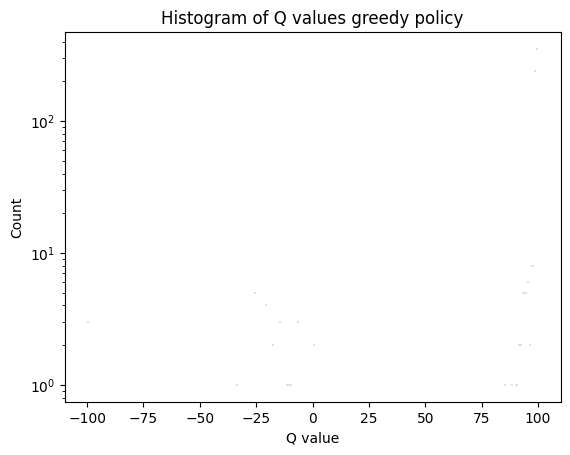

In [171]:
best_s, best_a = np.unravel_index(np.nanargmax(q_mcp_nan), (n_states, 7**3))
print("Global highest Q value {} for tv, fio2, peep ranges: {}".format(q_mcp_nan[best_s, best_a], utils.to_action_ranges(best_a)))
best_mean_a, best_mean_a_q = np.nanargmax(np.nanmean(q_mcp_nan, axis=0)), np.nanmax(np.nanmean(q_mcp_nan, axis=0))
print("Highest avg Q value across states {} for tv, fio2, peep ranges: {}".format(best_mean_a_q, utils.to_action_ranges(best_mean_a)))
best_med_a, best_med_a_q = np.nanargmax(np.nanmedian(q_mcp_nan, axis=0)), np.nanmax(np.nanmedian(q_mcp_nan, axis=0))
print("Highest median Q value across states {} for tv, fio2, peep ranges: {}".format(best_med_a, utils.to_action_ranges(best_med_a)))
sns.histplot(q_mcp_nan[mcp_greedy == 1.0].ravel(), log_scale=(False, True), bins=200)
plt.xlabel('Q value')
plt.title('Histogram of Q values greedy policy')
plt.show()

In [172]:
train_set['positive_outcome'] = train_set['mort90day'] == 'f'
estimated_mort_state_visit = train_set.groupby('state').mean('positive_outcome')[['positive_outcome']].to_numpy()

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\2318737839.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_set['positive_outcome'] = train_set['mort90day'] == 'f'


In [354]:
estimated_mort_state_visit[estimated_mort_state_visit == 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

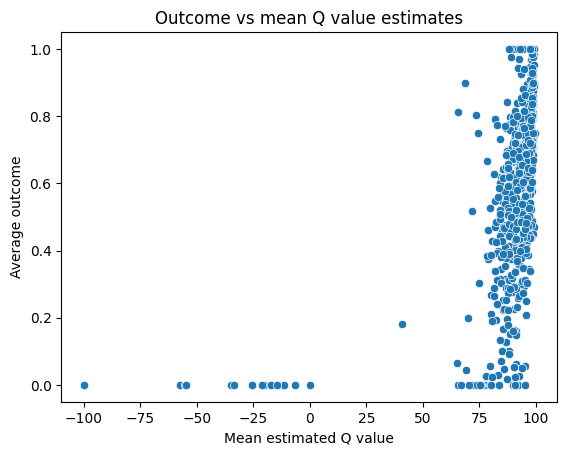

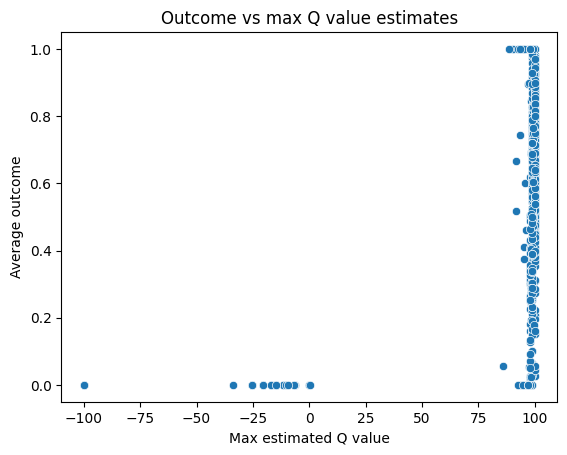

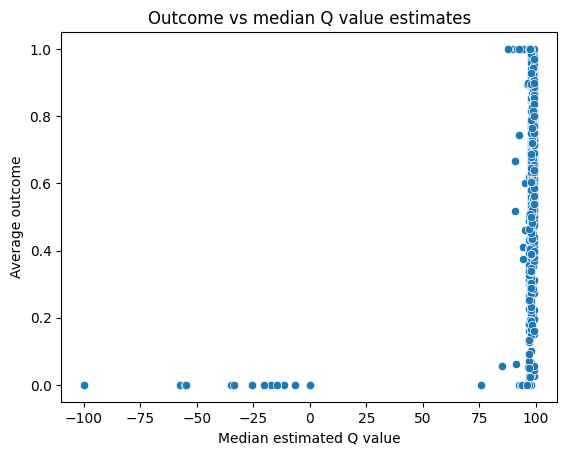

In [355]:
sns.scatterplot(x=np.nanmean(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Mean estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs mean Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmax(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Max estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs max Q value estimates')
plt.show()
sns.scatterplot(x=np.nanmedian(q_mcp_nan, axis=1), y=estimated_mort_state_visit.reshape(n_states,))
plt.xlabel('Median estimated Q value')
plt.ylabel('Average outcome')
plt.title('Outcome vs median Q value estimates')
plt.show()

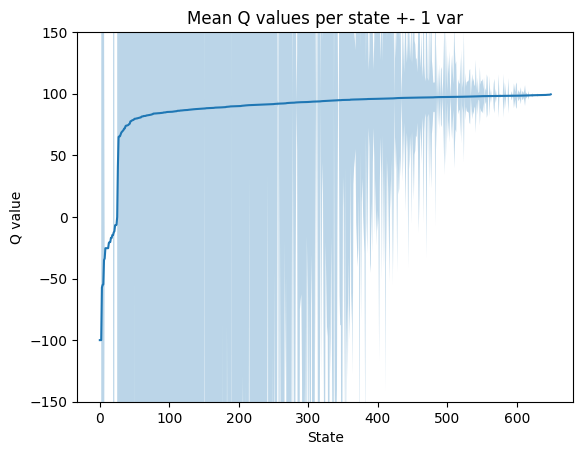

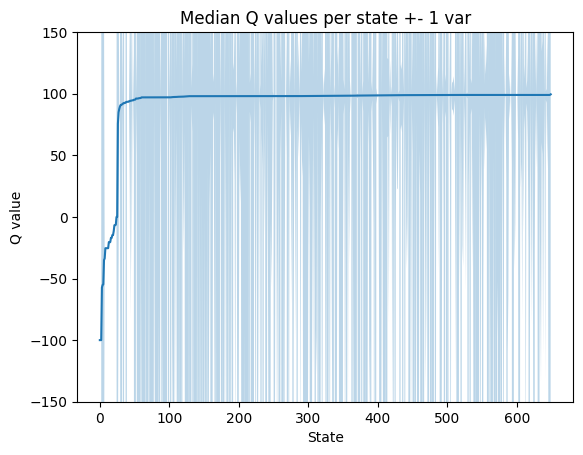

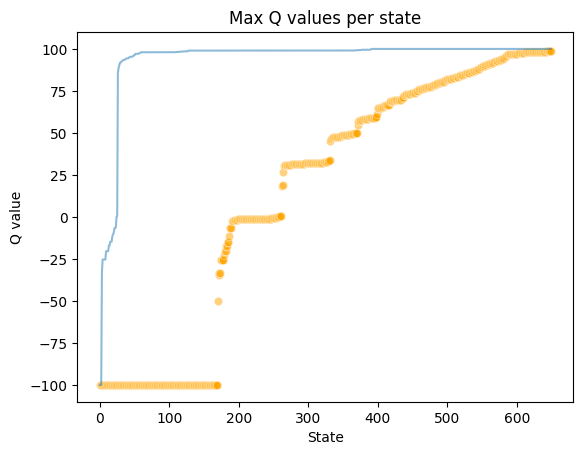

In [174]:
q_vars = np.nanvar(q_mcp_nan, axis=1)
q_means = np.nanmean(q_mcp_nan, axis=1)
q_medians = np.nanmedian(q_mcp_nan, axis=1)
q_maxs = np.nanmax(q_mcp_nan, axis=1)
q_mins = np.nanmin(q_mcp_nan, axis=1)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(n_states)
means_sorted = np.array(sorted(stacked, key=lambda x: x[0]))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per state +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: x[1]))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per state +- 1 var')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: x[3]))
axs = sns.scatterplot(x=xs, y=mins_sorted[:, 3], color='orange', alpha=.5)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per state')

maxs_sorted = np.array(sorted(stacked, key=lambda x: x[2]))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2], alpha=.5)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per state')
plt.show()


C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3327686320.py:4: RuntimeWarning: Degrees of freedom <= 0 for slice.
  q_vars = np.nanvar(q_mcp_nan, axis=0)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3327686320.py:5: RuntimeWarning: Mean of empty slice
  q_means = np.nanmean(q_mcp_nan, axis=0)
c:\Users\hmilab\Anaconda3\envs\VM_RL\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3327686320.py:7: RuntimeWarning: All-NaN slice encountered
  q_maxs = np.nanmax(q_mcp_nan, axis=0)
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\3327686320.py:8: RuntimeWarning: All-NaN slice encountered
  q_mins = np.nanmin(q_mcp_nan, axis=0)


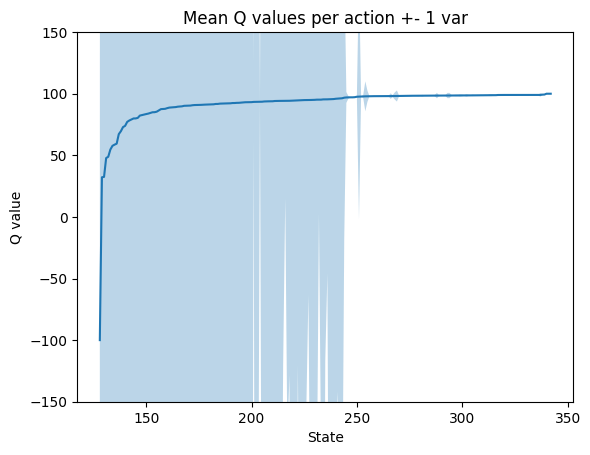

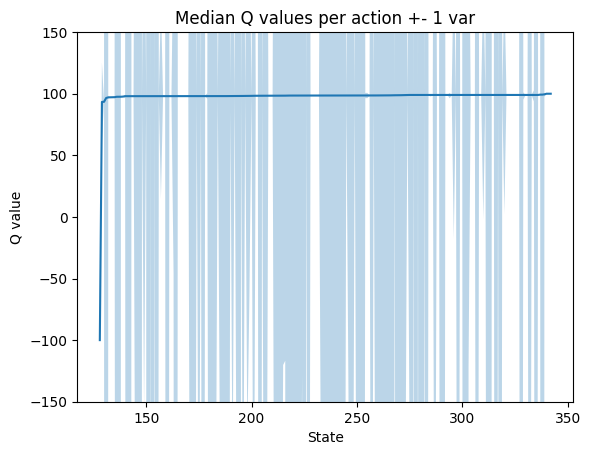

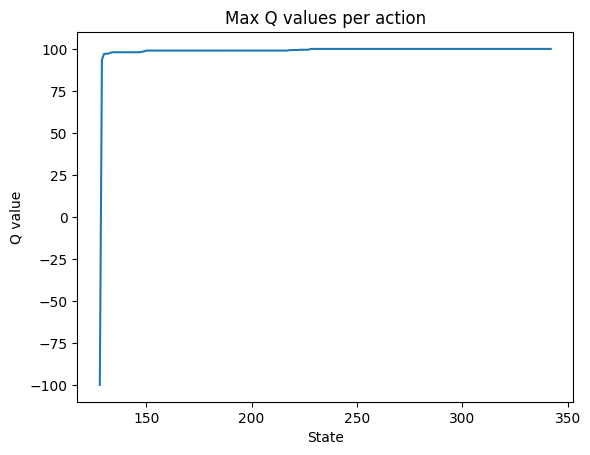

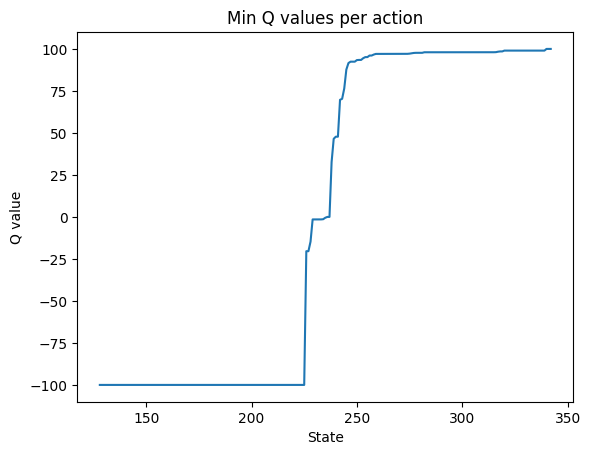

In [175]:
def sortnan(x, index):
    return float('-inf') if np.isnan(x[index]) else x[index]

q_vars = np.nanvar(q_mcp_nan, axis=0)
q_means = np.nanmean(q_mcp_nan, axis=0)
q_medians = np.nanmedian(q_mcp_nan, axis=0)
q_maxs = np.nanmax(q_mcp_nan, axis=0)
q_mins = np.nanmin(q_mcp_nan, axis=0)
stacked = np.column_stack((q_means, q_medians, q_maxs, q_mins, q_vars))
xs = range(7**3)
means_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 0)))
means_upper = means_sorted[:, 0] + means_sorted[:, -1]
means_lower = means_sorted[:, 0] - means_sorted[:, -1]
axs = sns.lineplot(x=xs, y=means_sorted[:, 0])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Mean Q values per action +- 1 var')
plt.show()

medians_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 1)))
means_upper = medians_sorted[:, 0] + medians_sorted[:, -1]
means_lower = medians_sorted[:, 0] - medians_sorted[:, -1]
axs = sns.lineplot(x=xs, y=medians_sorted[:, 1])
axs.fill_between(x=xs, y1=means_lower, y2=means_upper, alpha=.3)
axs.set_ylim(-150, 150)
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Median Q values per action +- 1 var')
plt.show()

maxs_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 2)))
axs = sns.lineplot(x=xs, y=maxs_sorted[:, 2])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Max Q values per action')
plt.show()

mins_sorted = np.array(sorted(stacked, key=lambda x: sortnan(x, 3)))
axs = sns.lineplot(x=xs, y=mins_sorted[:, 3])
plt.xlabel('State')
plt.ylabel('Q value')
plt.title('Min Q values per action')
plt.show()

In [176]:
behavior_policy_df = (test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state']))
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy_df = behavior_policy_df.reset_index()

In [177]:
# behavior_policy_pivot_temp = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')
# print(behavior_policy_pivot_temp.head())
# behavior_policy_df

In [178]:
print("Before reset_index: ")
print(behavior_policy_df.head())

behavior_policy_df_reset = behavior_policy_df.reset_index()
print("\nAfter reset_index: ")
print(behavior_policy_df_reset.head())

try:
    behavior_policy_pivot = behavior_policy_df_reset.pivot(columns='action_discrete', index='state')
    print("\nAfter pivot: ")
    print(behavior_policy_pivot.head())
except KeyError as e:
    print(f"\nError during pivot: {e}")
    print("\nColumns available after reset_index: ")
    print(behavior_policy_df_reset.columns)

# If there was an error selecting the column, this will check if 0 exists
if '0' in behavior_policy_pivot.columns:
    print("\nColumn '0' exists in the DataFrame.")
else:
    print("\nColumn '0' does not exist in the DataFrame. Columns available: ")
    print(behavior_policy_pivot.columns)

# This part checks the final DataFrame structure
print("\nFinal structure of behavior_policy_pivot: ")
print(behavior_policy_pivot.info())

Before reset_index: 
   state  action_discrete     count
0      0              184  0.093750
1      0              192  0.078125
2      0              136  0.078125
3      0              143  0.078125
4      0              170  0.062500

After reset_index: 
   index  state  action_discrete     count
0      0      0              184  0.093750
1      1      0              192  0.078125
2      2      0              136  0.078125
3      3      0              143  0.078125
4      4      0              170  0.062500

After pivot: 
                index                                                         
action_discrete   22  29  36  43  57  59  64  66  70    71  72  73  74  77    
state                                                                         
0                 NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN NaN NaN NaN NaN  \
1                 NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN NaN NaN NaN NaN   
2                 NaN NaN NaN NaN NaN NaN NaN NaN NaN   NaN NaN NaN NaN Na

In [179]:
# Assuming behavior_policy_pivot is the DataFrame you showed above

# To simplify, let's drop the top level ('count') since it's the same for all columns. This makes the DataFrame single-level.
behavior_policy_pivot.columns = behavior_policy_pivot.columns.droplevel(0)

# Now, your DataFrame has a simple single-level column index with action numbers.
# You can verify the structure
print(behavior_policy_pivot.columns)

# From here, you can proceed with filling missing actions, normalizing, etc.
# Example: Check if an action is missing and fill it with NaN or uniform probability as needed
expected_actions = set(range(1, 7**3 + 1))  # Adjust according to your actual range of actions
current_actions = set(behavior_policy_pivot.columns)
missing_actions = expected_actions - current_actions

# Fill missing actions with NaN (or with uniform probabilities as per your use case)
for action in missing_actions:
    behavior_policy_pivot[action] = np.nan  # or your default value

# Ensure all states have probabilities for all actions, filling missing values as needed
# Your code for normalizing probabilities and handling missing values will go here

# Finally, you can work on converting NaNs to zeros or normalizing the probabilities

Index([ 22,  29,  36,  43,  57,  59,  64,  66,  70,  71,
       ...
       323, 324, 325, 330, 331, 332, 335, 337, 338, 339],
      dtype='int64', name='action_discrete', length=346)


C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1383482888.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot[action] = np.nan  # or your default value


In [180]:
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy_df

state  action_discrete
0      170                0.164706
       185                0.105882
       135                0.105882
       184                0.094118
       193                0.070588
                            ...   
649    171                0.009434
       141                0.009434
       121                0.009434
       85                 0.009434
       232                0.009434
Name: count, Length: 15188, dtype: float64

In [471]:
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')
# behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3 # uniform distribution
        for i, p in enumerate(action_probs):
            behavior_policy_pivot.loc[s] = [s, i, p]

behavior_policy_pivot = behavior_policy_pivot.sort_values(['state'])

for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan

# TODO: timothy debug!!! avoid all nan due to the difference of behavior_policy_pivot['count'][70] and behavior_policy_pivot[70]
for col in behavior_policy_pivot['count'].keys():
    behavior_policy_pivot[col] =  behavior_policy_pivot['count'][col]

behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, "models/clinicians_policy_train_{}.bin".format(seed), compress=True)


C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\903090567.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\903090567.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\903090567.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

In [472]:
set(train_set.columns) - set(test_set.columns)

{'action_next',
 'compliance',
 'positive_outcome',
 'potential',
 'shaping_reward',
 'shaping_reward_unshift'}

In [183]:
""" # from chatGPT taking place of above
# Calculate the behavior policy DataFrame
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

# Reset the index and pivot the DataFrame
behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')

# Check if all states have been covered in the pivot
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3  # Uniform distribution for missing states
        behavior_policy_pivot.loc[s] = [s] + action_probs

# Sort the DataFrame by the state index
behavior_policy_pivot = behavior_policy_pivot.sort_values(by='state')

# Ensure all actions are included in the DataFrame
expected_actions = set(range(7**3))
current_actions = set(behavior_policy_pivot.columns.get_level_values(1))
missing_actions = expected_actions - current_actions

# Fill missing actions with NaN or default values
for action in missing_actions:
    behavior_policy_pivot[action] = np.nan  # or your default value

# Convert the DataFrame to a numpy array and handle NaN values
behavior_policy_nan = behavior_policy_pivot.to_numpy()
behavior_policy_nan[np.isnan(behavior_policy_nan)] = 0.0  # Fill NaN with zeros

# Ensure policy action probabilities sum to 1 per state
assert (1 - np.sum(behavior_policy_nan, axis=1) < 1e10).all(), "Policy action probs should sum to 1 per state"

# Assert that the behavior policy shape matches the expected dimensions
assert behavior_policy_nan.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"

# Check that the greedy policy mask correctly masks out all-but-one action
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"

# Save the behavior policy if the unsafety probability is 1.0
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy_nan, "models/clinicians_policy_train_{}.bin".format(seed), compress=True)
 """

' # from chatGPT taking place of above\n# Calculate the behavior policy DataFrame\nbehavior_policy_df = train_set.value_counts([\'state\', \'action_discrete\']) / train_set.value_counts([\'state\'])\nassert (1.0 - behavior_policy_df.groupby(\'state\').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"\n\n# Reset the index and pivot the DataFrame\nbehavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns=\'action_discrete\', index=\'state\')\n\n# Check if all states have been covered in the pivot\nbehavior_policy_states = set(behavior_policy_pivot.index.unique())\nfor s in range(n_states):\n    if s not in behavior_policy_states:\n        action_probs = [1.0 / (7**3),] * 7**3  # Uniform distribution for missing states\n        behavior_policy_pivot.loc[s] = [s] + action_probs\n\n# Sort the DataFrame by the state index\nbehavior_policy_pivot = behavior_policy_pivot.sort_values(by=\'state\')\n\n# Ensure all actions are included in the DataFrame\nexpected_act

ERROR PART

In [473]:
behavior_policy_df = train_set.value_counts(['state', 'action_discrete']) / train_set.value_counts(['state'])
behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')
behavior_policy_pivot

count                                                           
action_discrete   15  22  23  29  36  37  38  39  43  44  45  56  57  58  59    
state                                                                           
0                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  \
1                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
...               ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
645               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
646               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
647               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
648               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
649               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

                                                                                
action_discrete 64  65  66  67        70        71        72  73  74  76  77    
state                                                                           
0               NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN  \
1               NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
2               NaN NaN NaN NaN  0.003021  0.009063       NaN NaN NaN NaN NaN   
3               NaN NaN NaN NaN       NaN  0.011696       NaN NaN NaN NaN NaN   
4               NaN NaN NaN NaN       NaN       NaN  0.005747 NaN NaN NaN NaN   
...              ..  ..  ..  ..       ...       ...       ...  ..  ..  ..  ..   
645             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
646             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
647             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
648             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
649             NaN NaN NaN NaN       NaN  0.028302       NaN NaN NaN NaN NaN   

                                                                                
action_discrete 78  79  80  81  84        85  86  87  88  89  90  92  93  94    
state                                                                           
0               NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN  \
1               NaN NaN NaN NaN NaN  0.004673 NaN NaN NaN NaN NaN NaN NaN NaN   
2               NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3               NaN NaN NaN NaN NaN  0.023392 NaN NaN NaN NaN NaN NaN NaN NaN   
4               NaN NaN NaN NaN NaN  0.005747 NaN NaN NaN NaN NaN NaN NaN NaN   
...              ..  ..  ..  ..  ..       ...  ..  ..  ..  ..  ..  ..  ..  ..   
645             NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN   
646             NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN   
647             NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN   
648             NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN   
649             NaN NaN NaN NaN NaN  0.009434 NaN NaN NaN NaN NaN NaN NaN NaN   

                                                                                
action_discrete 95  96  97  99  100 105 106 107 108 109 112 113 114       115   
state                                                                           
0               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN  \
1               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN   
2               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.003021   
3               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN   
4               NaN NaN NaN NaN NaN NaN NaN 

In [474]:
behavior_policy_df = test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state'])
behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')
behavior_policy_pivot = behavior_policy_pivot.reindex(range(650))
behavior_policy_pivot

count                                                          
action_discrete   22  29  36  43  57  59  64  66  70     71  72  73  74  77    
state                                                                          
0                 NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN  \
1                 NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
2                 NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
3                 NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.025 NaN NaN NaN NaN   
4                 NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
...               ...  ..  ..  ..  ..  ..  ..  ..  ..    ...  ..  ..  ..  ..   
645               NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
646               NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
647               NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
648               NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   
649               NaN NaN NaN NaN NaN NaN NaN NaN NaN    NaN NaN NaN NaN NaN   

                                                                              
action_discrete       78  79  80  81  84  85        86  87  88  92  93  94    
state                                                                         
0                     NaN NaN NaN NaN NaN NaN  0.015625 NaN NaN NaN NaN NaN  \
1                     NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
2                0.009524 NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
3                     NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
4                     NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
...                   ...  ..  ..  ..  ..  ..       ...  ..  ..  ..  ..  ..   
645                   NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
646                   NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
647                   NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
648                   NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   
649                   NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN   

                                                                                
action_discrete 95  99  100 105       106 107 108 109 112       113       114   
state                                                                           
0               NaN NaN NaN NaN  0.015625 NaN NaN NaN NaN       NaN       NaN  \
1               NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   
2               NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   
3               NaN NaN NaN NaN  0.187500 NaN NaN NaN NaN       NaN       NaN   
4               NaN NaN NaN NaN       NaN NaN NaN NaN NaN  0.028986  0.014493   
...              ..  ..  ..  ..       ...  ..  ..  ..  ..       ...       ...   
645             NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   
646             NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   
647             NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   
648             NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   
649             NaN NaN NaN NaN       NaN NaN NaN NaN NaN       NaN       NaN   

                                                                        
action_discrete 115 119       120       121       122 123 124 125 126   
state                                                                   
0               NaN NaN       NaN  0.015625  0.031250 NaN NaN NaN NaN  \
1               NaN NaN  0.019048       NaN       NaN NaN NaN NaN NaN   
2               NaN NaN  0.142857       NaN       NaN NaN NaN NaN NaN   
3               NaN NaN  0.137500       NaN       NaN NaN NaN NaN NaN   
4               NaN NaN  0.028986  0.043478  0.028986 NaN NaN NaN NaN   
...              ..  ..       ...       ...       ...  ..  ..  ..  ..

In [220]:
behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')
behavior_policy_pivot

count                                                           
action_discrete   15  22  23  29  36  37  38  39  43  44  45  56  57  58  59    
state                                                                           
0                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  \
1                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4                 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
...               ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
645               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
646               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
647               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
648               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
649               NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   

                                                                                
action_discrete 64  65  66  67        70        71        72  73  74  76  77    
state                                                                           
0               NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN  \
1               NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
2               NaN NaN NaN NaN  0.002294  0.006881       NaN NaN NaN NaN NaN   
3               NaN NaN NaN NaN       NaN  0.015936       NaN NaN NaN NaN NaN   
4               NaN NaN NaN NaN       NaN       NaN  0.004115 NaN NaN NaN NaN   
...              ..  ..  ..  ..       ...       ...       ...  ..  ..  ..  ..   
645             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
646             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
647             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
648             NaN NaN NaN NaN       NaN       NaN       NaN NaN NaN NaN NaN   
649             NaN NaN NaN NaN       NaN  0.022059       NaN NaN NaN NaN NaN   

                                                                                
action_discrete       78  79  80  81  84        85        86  87  88  89  90    
state                                                                           
0                     NaN NaN NaN NaN NaN       NaN  0.006711 NaN NaN NaN NaN  \
1                     NaN NaN NaN NaN NaN  0.003135       NaN NaN NaN NaN NaN   
2                0.002294 NaN NaN NaN NaN       NaN       NaN NaN NaN NaN NaN   
3                     NaN NaN NaN NaN NaN  0.015936       NaN NaN NaN NaN NaN   
4                     NaN NaN NaN NaN NaN  0.004115       NaN NaN NaN NaN NaN   
...                   ...  ..  ..  ..  ..       ...       ...  ..  ..  ..  ..   
645                   NaN NaN NaN NaN NaN       NaN       NaN NaN NaN NaN NaN   
646                   NaN NaN NaN NaN NaN       NaN       NaN NaN NaN NaN NaN   
647                   NaN NaN NaN NaN NaN       NaN       NaN NaN NaN NaN NaN   
648                   NaN NaN NaN NaN NaN       NaN       NaN NaN NaN NaN NaN   
649                   NaN NaN NaN NaN NaN  0.007353       NaN NaN NaN NaN NaN   

                                                                                
action_discrete 92  93  94  95  96  97  99  100 105       106 107 108 109 112   
state                                                                           
0               NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.006711 NaN NaN NaN NaN  \
1               NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN   
2               NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN   
3               NaN NaN NaN NaN NaN NaN NaN NaN NaN  0.059761 NaN NaN NaN NaN   
4               NaN NaN NaN NaN NaN NaN NaN 

In [475]:
behavior_policy_df = test_set.value_counts(['state', 'action_discrete']) / test_set.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state') # TODO: timothy debug
behavior_policy_pivot = behavior_policy_pivot.reindex(range(650)) # TODO: timothy debug

# behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]

for a in range(7**3):
    if a not in behavior_policy_pivot.columns:
        behavior_policy_pivot.loc[:, a] = np.nan
        
behavior_policy_states = set(behavior_policy_pivot.index.unique())
for s in range(n_states):
    if s not in behavior_policy_states:
        action_probs = [1.0 / (7**3),] * 7**3 # uniform distribution
        for i, p in enumerate(action_probs):
            # behavior_policy_pivot.loc[s] = [s] + action_probs
            behavior_policy_pivot.loc[s] = [1/(7**3),]*(7**3)

behavior_policy_pivot = behavior_policy_pivot.sort_values(['state'])

# TODO: timothy debug!!! avoid all nan due to the difference of behavior_policy_pivot['count'][70] and behavior_policy_pivot[70]
for col in behavior_policy_pivot['count'].keys():
    behavior_policy_pivot[col] =  behavior_policy_pivot['count'][col]
    
behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy()
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, "models/clinicians_policy_test_{}.bin".format(seed), compress=True)

C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1961995331.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1961995331.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1961995331.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [476]:
behavior_policy[70]

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [477]:
train_test = pd.concat([train_set, test_set])
behavior_policy_df = train_test.value_counts(['state', 'action_discrete']) / train_test.value_counts(['state'])
assert (1.0 - behavior_policy_df.groupby('state').sum() < 1e10).all(), "Policy action probs should sum to 1 per state"

behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state') # TODO: timothy debug
# behavior_policy_pivot = behavior_policy_df.reset_index().pivot(columns='action_discrete', index='state')[0]
# print(list(behavior_policy_pivot['count'].columns))
# print(5 in list(behavior_policy_pivot['count'].columns))
# print(behavior_policy_pivot['count'][70])
# print(behavior_policy_pivot['count'].shape)
for a in range(7**3):
    # if a not in list(behavior_policy_pivot['count'].columns): # TODO: timothy debug 2024/5/2
    if a not in behavior_policy_pivot.columns: # original one, but output will all be zero
        behavior_policy_pivot.loc[:, a] = np.nan
# print(behavior_policy_pivot.head())
# print(behavior_policy_pivot['count'][70])
# print(behavior_policy_pivot['count'].keys())

# TODO: timothy debug 2024/05/02 !!! avoid all nan due to the difference of behavior_policy_pivot['count'][70] and behavior_policy_pivot[70]
for col in behavior_policy_pivot['count'].keys():
    behavior_policy_pivot[col] =  behavior_policy_pivot['count'][col]

# print(behavior_policy_pivot['count'].keys())
# print(behavior_policy_pivot[70]) # TODO: timothy I think this is bug -> all Nan
# behavior_policy_nan = behavior_policy_pivot['count'][range(7**3)].to_numpy() # TODO: timothy debug, but wrong
behavior_policy_nan = behavior_policy_pivot[range(7**3)].to_numpy() # original version
# print(behavior_policy_nan[69])
assert (1- (np.nansum(behavior_policy_nan, axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
behavior_policy = np.nan_to_num(behavior_policy_nan, 0.0)
assert (1- (behavior_policy.sum(axis=1)) < 1e10).all(), "Policy action probs should sum to 1 per state"
assert behavior_policy.shape == (n_states, 7**3), "Behavior policy should cover all states and actions"
mcp_greedy_mask = mcp_greedy.astype(bool)
assert (mcp_greedy_mask.sum(axis=1) == 1).all(), "Greedy policy mask should mask out all-but-one action"
if UNSAFETY_PROB == 1.0:
    joblib.dump(behavior_policy, "models/clinicians_policy_train_test_{}.bin".format(seed), compress=True)


C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1913155070.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1913155070.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  behavior_policy_pivot.loc[:, a] = np.nan
C:\Users\hmilab\AppData\Local\Temp\ipykernel_8116\1913155070.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

In [478]:
# behavior_policy_pivot[behavior_policy_pivot['state'] == 0]
behavior_policy_pivot['count']
# behavior_policy_pivot[0]['action_discrete']

action_discrete,15,22,23,29,36,37,38,39,43,44,45,56,57,58,59,64,65,66,67,70,71,72,73,74,76,77,78,79,80,81,84,85,86,87,88,89,90,92,93,94,95,96,97,99,100,105,106,107,108,109,112,113,114,115,116,119,120,121,122,123,124,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,154,155,156,157,158,159,161,162,163,164,165,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,197,203,204,205,206,207,210,211,212,213,217,218,219,220,221,222,223,224,225,226,227,228,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,246,252,253,254,255,259,260,261,262,266,267,268,269,270,272,274,275,276,277,280,281,282,283,284,285,286,287,288,289,290,291,292,293,302,303,309,310,316,317,318,319,323,324,325,326,330,331,332,333,335,336,337,338,339,340,342
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006711,0.020134,NaN,NaN,NaN,NaN,0.013423,0.020134,0.006711,NaN,NaN,NaN,0.046980,0.087248,0.053691,0.013423,NaN,NaN,NaN,0.013423,0.020134,0.046980,0.013423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013423,0.120805,0.013423,0.033557,NaN,NaN,NaN,0.013423,0.020134,0.020134,NaN,NaN,NaN,NaN,0.026846,0.093960,0.073826,0.013423,NaN,NaN,NaN,0.020134,0.033557,0.046980,0.040268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006711,NaN,NaN,0.006711,NaN,NaN,NaN,NaN,NaN,0.006711,NaN,NaN,NaN,NaN,NaN,NaN,0.006711,0.013423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006270,0.018809,NaN,NaN,NaN,NaN,NaN,NaN,0.006270,NaN,NaN,NaN,NaN,0.003135,0.040752,0.012539,0.003135,NaN,NaN,NaN,NaN,0.006270,NaN,NaN,NaN,NaN,NaN,0.003135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003135,0.072100,0.021944,0.003135,NaN,NaN,NaN,NaN,0.009404,0.006270,NaN,NaN,NaN,NaN,NaN,0.169279,0.037618,0.018809,0.003135,NaN,NaN,NaN,0.097179,0.028213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.072100,0.003135,NaN,NaN,NaN,NaN,NaN,0.018809,0.003135,0.003135,NaN,NaN,NaN,0.166144,0.015674,0.003135,0.009404,NaN,NaN,0.003135,0.050157,0.009404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018809,0.021944,NaN,NaN,NaN,NaN,0.00627,0.003135,0.006270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002294,0.006881,NaN,NaN,NaN,NaN,NaN,0.002294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002294,NaN,NaN,0.194954,NaN,NaN,NaN,NaN,NaN,NaN,0.006881,0.002294,NaN,NaN,NaN,NaN,0.096330,0.004587,NaN,NaN,NaN,NaN,NaN,0.004587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002294,NaN,NaN,NaN,NaN,NaN,0.004587,NaN,NaN,NaN,0.009174,0.403670,0.002294,NaN,NaN,NaN,NaN,NaN,0.016055,NaN,NaN,NaN,NaN,NaN,NaN,0.114679,0.002294,NaN,NaN,NaN,NaN,NaN,0.006881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002294,NaN,NaN,NaN,0.057339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002294,0.032110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [409]:
list(behavior_policy_pivot['count'].columns)

[15,
 22,
 23,
 29,
 36,
 37,
 38,
 39,
 43,
 44,
 45,
 56,
 57,
 58,
 59,
 64,
 65,
 66,
 67,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 99,
 100,
 105,
 106,
 107,
 108,
 109,
 112,
 113,
 114,
 115,
 116,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 162,
 163,
 164,
 165,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 197,
 203,
 204,
 205,
 206,
 207,
 210,
 211,
 212,
 213,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 246,
 252,
 253,
 254,
 255,
 259,
 260,
 261,
 262,
 266,
 267,
 268,


In [479]:
import scipy
scipy.stats.entropy(behavior_policy.ravel())

9.004843579555924

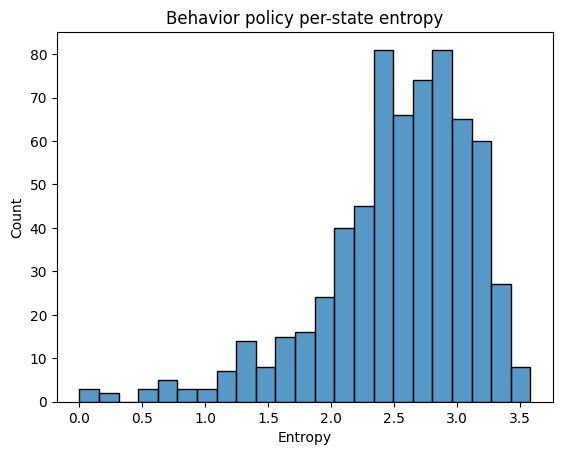

In [480]:
sns.histplot(scipy.stats.entropy(behavior_policy, axis=1))
plt.title('Behavior policy per-state entropy')
plt.xlabel('Entropy') 
plt.show()

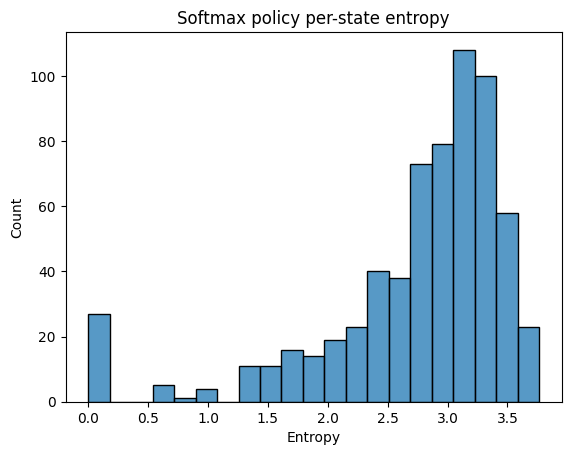

In [481]:
sns.histplot(scipy.stats.entropy(mcp_softmax, axis=1))
plt.title('Softmax policy per-state entropy')
plt.xlabel('Entropy')
plt.show()

Behavior policy argmax and greedy policy agreement: 0.04153846153846154


(0.002036659877800407, 1.0)

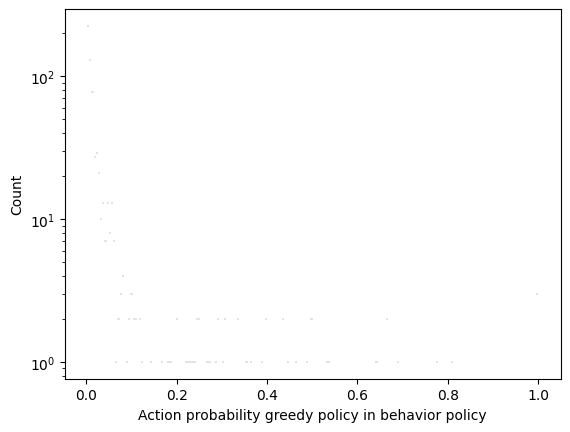

In [482]:
print("Behavior policy argmax and greedy policy agreement: {}".format((behavior_policy.argmax(axis=1) == mcp_greedy.argmax(axis=1)).sum() / n_states))
sns.histplot(behavior_policy[mcp_greedy_mask], log_scale=(False, True))
plt.xlabel('Action probability greedy policy in behavior policy')
behavior_policy[mcp_greedy_mask].min(), behavior_policy[mcp_greedy_mask].max()

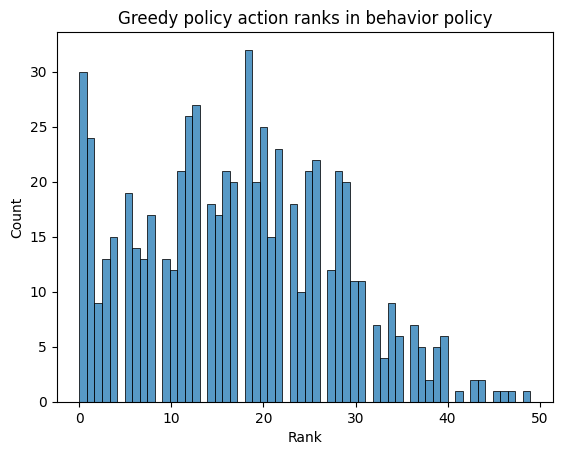

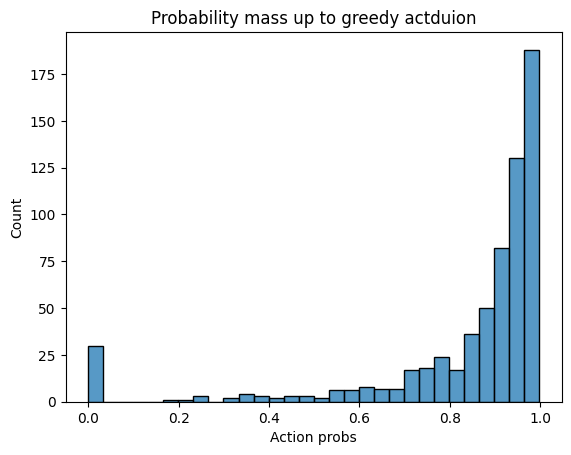

(0.0, 0.9974093264248705)

In [483]:
evaluation_policy = mcp_greedy

behavior_policy_ranks = np.flip(behavior_policy.argsort(axis=1), axis=1)
ep_bp_ranks = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_ranks.append(bp_rank)

sns.histplot(ep_bp_ranks, bins=60)
plt.title('Greedy policy action ranks in behavior policy')
plt.xlabel('Rank')
plt.show()

behavior_policy_ranked_probs = np.flip(np.sort(behavior_policy, axis=1), axis=1)
ep_bp_prob_mass = []
for s in range(n_states):
    ep_a = evaluation_policy[s,:].argmax()
    bp_rank = np.where(behavior_policy_ranks[s, :] == ep_a)[0][0]
    ep_bp_prob_mass.append(behavior_policy_ranked_probs[s, 0:bp_rank].sum())

sns.histplot(ep_bp_prob_mass)
plt.title('Probability mass up to greedy actduion')
plt.xlabel('Action probs')
plt.show()
np.array(ep_bp_prob_mass).min(), np.array(ep_bp_prob_mass).max()

In [484]:
# state-values of 

In [485]:
joblib.dump(mcp_greedy, "models/mcp_greedy_policy_{}_{}_{}.bin".format(seed, shaping_name, UNSAFETY_PROB), compress=True)
joblib.dump(mcp_softmax, "models/mcp_softmax_policy_{}_{}_{}.bin".format(seed, shaping_name, UNSAFETY_PROB), compress=True)


['models/mcp_softmax_policy_12_avgpotential2-0.0_1.0.bin']

In [486]:
mcp_softmax[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [487]:
print('test')

test


In [488]:
import importlib.util
importlib.reload(safety)

<module 'safety' from 'd:\\Timothy_Chang\\Guideline_informed_paper_code\\guideline-informed-vent-rl\\scripts\\safety.py'>